### Decision Tree ###

In [122]:
import pandas as pd

In [123]:
#df = pd.read_csv("../data/kickstarter_cleaned.csv")
#df = pd.read_csv("../data/kickstarter_one_hot_cleaned.csv")
#df = pd.read_csv("../data/kickstarter_final_data.csv")

df = pd.read_csv("../data/final.csv")

In [124]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#eliminate all non-numerical columns
df = df.select_dtypes(include=['number'])

#y is the target feature
y = df['SuccessfulBool']
#X consists of all features other than the target feature
X = df.drop('SuccessfulBool', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)

In [125]:
for i in range(1, 5):
    clf = DecisionTreeClassifier(max_depth=i, random_state=42)
    clf.fit(X_train, y_train)

    cv_scores = cross_val_score(clf, X, y, cv=10)

    #examine the feature importance
    importances = clf.feature_importances_
    feature_ranks = pd.Series(importances, index=X.columns).sort_values(ascending=False)
    print(feature_ranks)

    print(f"Tree depth {i}")
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean accuracy: {cv_scores.mean():.4f}")
    print(f"Standard deviation of accuracy: {cv_scores.std():.4f}")

    y_scores = clf.predict_proba(X_test)[:, 1]  # Get probability for the positive class

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    '''
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Chance line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    '''

goal                           1.0
deadline_weekday_Saturday      0.0
created_at_weekday_Thursday    0.0
created_at_weekday_Sunday      0.0
created_at_weekday_Saturday    0.0
                              ... 
world                          0.0
new                            0.0
help                           0.0
app                            0.0
category_grouped_Web           0.0
Length: 73, dtype: float64
Tree depth 1
Cross-validation scores: [0.51501938 0.70833333 0.70867668 0.70867668 0.70819195 0.70819195
 0.70819195 0.70819195 0.70819195 0.70819195]
Mean accuracy: 0.6890
Standard deviation of accuracy: 0.0580
goal                            0.531886
category_grouped_Web            0.244990
create_to_launch_days           0.223124
name_len_clean                  0.000000
created_at_weekday_Wednesday    0.000000
                                  ...   
currency_grouped_GBP            0.000000
currency_grouped_Other          0.000000
currency_grouped_USD            0.000000
deadlin

In [126]:
#drop spotlight and any other features that will leak

'''features_to_drop = ['usd_pledged', 'state_changed_at', 'staff_pick', 'backers_count', 'spotlight', 'launch_to_state_change_days', 'state_changed_at_weekday_Friday', 'state_changed_at_weekday_Monday', 'state_changed_at_weekday_Saturday', 'state_changed_at_weekday_Sunday', 'state_changed_at_weekday_Thursday', 'state_changed_at_weekday_Tuesday', 'state_changed_at_weekday_Wednesday']
print(df.columns.to_list())

def safe_drop_columns(df, features_to_drop):
    for column in features_to_drop:
        if column in df.columns.tolist():
            df.drop(column, axis=1, inplace=True)
safe_drop_columns(df, features_to_drop)'''

#print(df.columns)

#print('usd_pledged' in df.columns)

#y is the target feature
#y = df['SuccessfulBool']
#X consists of all features other than the target feature
#X = df.drop('SuccessfulBool', axis=1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

"features_to_drop = ['usd_pledged', 'state_changed_at', 'staff_pick', 'backers_count', 'spotlight', 'launch_to_state_change_days', 'state_changed_at_weekday_Friday', 'state_changed_at_weekday_Monday', 'state_changed_at_weekday_Saturday', 'state_changed_at_weekday_Sunday', 'state_changed_at_weekday_Thursday', 'state_changed_at_weekday_Tuesday', 'state_changed_at_weekday_Wednesday']\nprint(df.columns.to_list())\n\ndef safe_drop_columns(df, features_to_drop):\n    for column in features_to_drop:\n        if column in df.columns.tolist():\n            df.drop(column, axis=1, inplace=True)\nsafe_drop_columns(df, features_to_drop)"

In [146]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer, f1_score
import numpy as np

#thresholds = np.arange()

def grid_search_roc_auc_tree(X, y, param_grid, cv=10, random_state=42, return_feature_importance=False, return_cv_scores=False):
    clf = DecisionTreeClassifier(random_state=42)
    grid = GridSearchCV(clf, param_grid, scoring='accuracy', cv=10)
    grid.fit(X_train, y_train)

    # Now get the best model
    best_model = grid.best_estimator_

    # Predict probabilities
    y_probs = best_model.predict_proba(X_test)[:, 1]  # Use a validation set here

    # Try different thresholds manually
    thresholds = np.arange(0.1, 0.7, 0.1)
    best_threshold_score = {'thresh': None, 'f1': None}
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        score = f1_score(y_test, y_pred)
        print(f"Threshold: {t:.2f} -> F1 Score: {score:.4f}")
        if(best_threshold_score['thresh'] == None):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score
        elif(score > best_threshold_score['f1']):
            best_threshold_score['thresh'] = t
            best_threshold_score['f1'] = score

    return {
        'cv_accuracy': grid.best_score_,
        'best_params': grid.best_params_,
        'best_thresh': best_threshold_score
    }

    
    '''results = []

    for param in ParameterGrid(param_grid):


        clf = DecisionTreeClassifier(**param, random_state=random_state)
        clf.fit(X_train, y_train)

        #automatically stratifies
        cv_scores = cross_val_score(clf, X, y, cv=10)
        print(f"mean_cv score: {np.mean(cv_scores)}")

        #examine the feature importance
        importances = clf.feature_importances_
        feature_ranks = pd.Series(importances, index=X.columns).sort_values(ascending=False)

        y_scores = clf.predict_proba(X_test)[:, 1]  # Get probability for the positive class
        print(f"mean y_pos_score: {np.mean(y_scores)}")

        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)
        print(f"roc_auc: {roc_auc}")

        result = {
            "params": param,
            "mean_cv": np.mean(cv_scores),
            "std_cv": np.std(cv_scores),
            "roc_auc": roc_auc,
            "y_pos_avg_score": np.mean(y_scores),
            "y_pos_std": np.std(y_scores)
        }

        if return_feature_importance:
            result['importances'] = feature_ranks

        print("=============")

        results.append(result)


    df_results = pd.DataFrame(results)
    df_results = df_results.sort_values(by="roc_auc", ascending=False)
    return df_results'''
        

In [151]:

decision_tree_param_grid = {
    'max_depth': range(5, 25),#25
    'min_samples_leaf': range(2, 15), #15
    'min_samples_split': range(10, 15)
}

#def grid_search_roc_auc_tree(X, y, param_grid, cv=10, random_state=42, return_feature_importance=False, return_cv_scores=False):

result = grid_search_roc_auc_tree(X, y, param_grid=decision_tree_param_grid, return_feature_importance=False, return_cv_scores=False)

'''top_model_cv_aucs = results_df.iloc[0]['cv_aucs']
print(top_model_cv_aucs)
print(results_df.iloc[0]['params'])'''

print(result)


Threshold: 0.10 -> F1 Score: 0.5725
Threshold: 0.20 -> F1 Score: 0.5947
Threshold: 0.30 -> F1 Score: 0.6004
Threshold: 0.40 -> F1 Score: 0.5858
Threshold: 0.50 -> F1 Score: 0.4764
Threshold: 0.60 -> F1 Score: 0.3778
{'cv_accuracy': np.float64(0.7531489806285885), 'best_params': {'max_depth': 11, 'min_samples_leaf': 13, 'min_samples_split': 10}, 'best_thresh': {'thresh': np.float64(0.30000000000000004), 'f1': 0.6003668229060526}}


Tree depth 4
min_samples_leaf 2
goal                     0.540420
category_grouped_Web     0.247963
create_to_launch_days    0.211617
dtype: float64
Cross-validation scores: [0.51501938 0.59253876 0.70867668 0.79301987 0.63305865 0.70431411
 0.6980126  0.71013088 0.70964615 0.68880271]
Mean accuracy: 0.6753
Standard deviation of accuracy: 0.0730


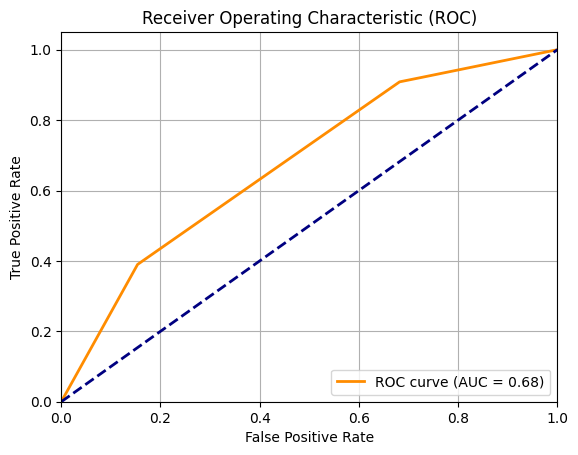

Tree depth 4
min_samples_leaf 3
goal                     0.540420
category_grouped_Web     0.247963
create_to_launch_days    0.211617
dtype: float64
Cross-validation scores: [0.51501938 0.59253876 0.70867668 0.79301987 0.63305865 0.70431411
 0.6980126  0.71013088 0.70964615 0.68880271]
Mean accuracy: 0.6753
Standard deviation of accuracy: 0.0730


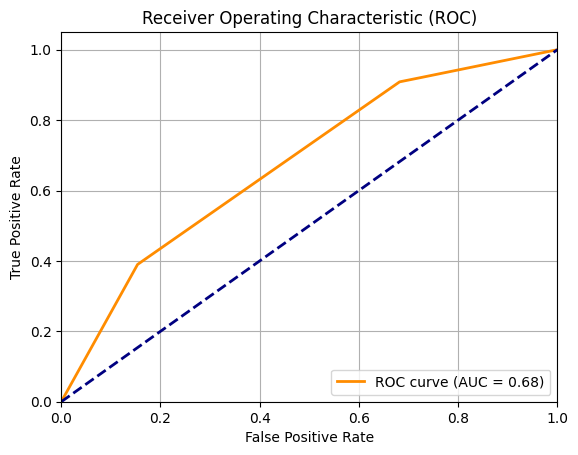

Tree depth 4
min_samples_leaf 4
goal                     0.540420
category_grouped_Web     0.247963
create_to_launch_days    0.211617
dtype: float64
Cross-validation scores: [0.51501938 0.59253876 0.70867668 0.79301987 0.63305865 0.70431411
 0.6980126  0.71013088 0.70964615 0.68880271]
Mean accuracy: 0.6753
Standard deviation of accuracy: 0.0730


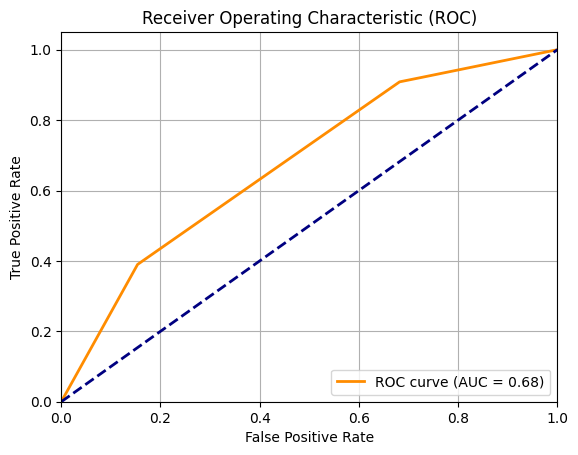

Tree depth 4
min_samples_leaf 5
goal                     0.540420
category_grouped_Web     0.247963
create_to_launch_days    0.211617
dtype: float64
Cross-validation scores: [0.51501938 0.59253876 0.70867668 0.79301987 0.63305865 0.70431411
 0.6980126  0.71013088 0.70964615 0.68880271]
Mean accuracy: 0.6753
Standard deviation of accuracy: 0.0730


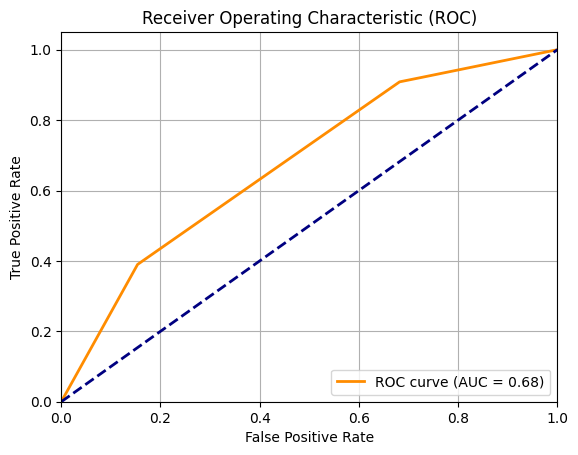

Tree depth 4
min_samples_leaf 6
goal                     0.540420
category_grouped_Web     0.247963
create_to_launch_days    0.211617
dtype: float64
Cross-validation scores: [0.51501938 0.59253876 0.70867668 0.79301987 0.63305865 0.70431411
 0.6980126  0.71013088 0.70964615 0.68880271]
Mean accuracy: 0.6753
Standard deviation of accuracy: 0.0730


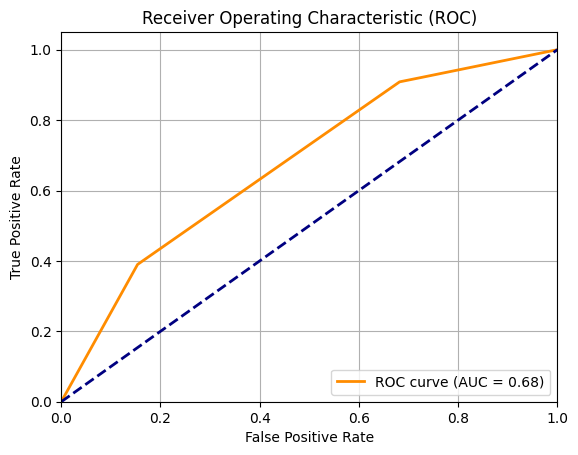

Tree depth 4
min_samples_leaf 7
goal                     0.540420
category_grouped_Web     0.247963
create_to_launch_days    0.211617
dtype: float64
Cross-validation scores: [0.51501938 0.59253876 0.70867668 0.79301987 0.63305865 0.70431411
 0.6980126  0.71013088 0.70964615 0.68880271]
Mean accuracy: 0.6753
Standard deviation of accuracy: 0.0730


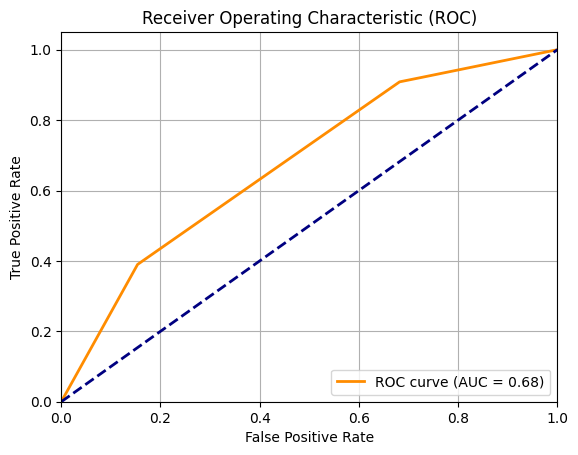

Tree depth 4
min_samples_leaf 8
goal                     0.540420
category_grouped_Web     0.247963
create_to_launch_days    0.211617
dtype: float64
Cross-validation scores: [0.51501938 0.59253876 0.70867668 0.79301987 0.63305865 0.70431411
 0.6980126  0.71013088 0.70964615 0.68880271]
Mean accuracy: 0.6753
Standard deviation of accuracy: 0.0730


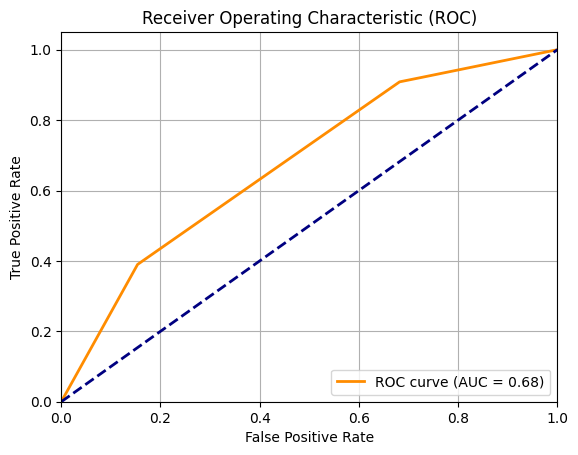

Tree depth 4
min_samples_leaf 9
goal                     0.540420
category_grouped_Web     0.247963
create_to_launch_days    0.211617
dtype: float64
Cross-validation scores: [0.51501938 0.59253876 0.70867668 0.79301987 0.63305865 0.70431411
 0.6980126  0.71013088 0.70964615 0.68880271]
Mean accuracy: 0.6753
Standard deviation of accuracy: 0.0730


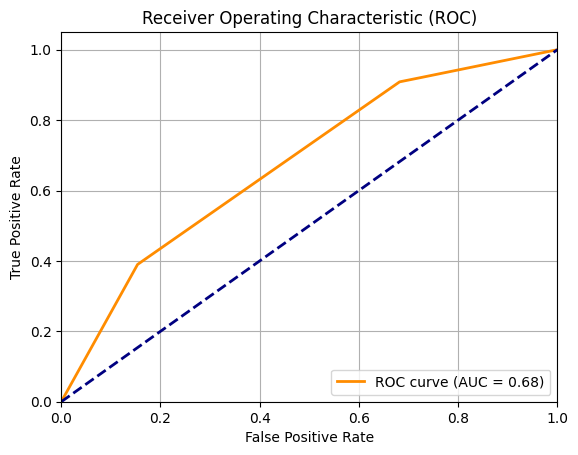

Tree depth 4
min_samples_leaf 10
goal                     0.540420
category_grouped_Web     0.247963
create_to_launch_days    0.211617
dtype: float64
Cross-validation scores: [0.51501938 0.59253876 0.70867668 0.79301987 0.63305865 0.70431411
 0.6980126  0.71013088 0.70964615 0.68880271]
Mean accuracy: 0.6753
Standard deviation of accuracy: 0.0730


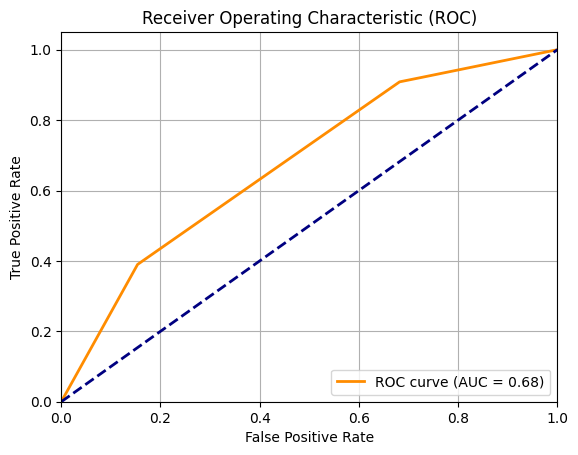

Tree depth 4
min_samples_leaf 11
goal                     0.540420
category_grouped_Web     0.247963
create_to_launch_days    0.211617
dtype: float64
Cross-validation scores: [0.51501938 0.59253876 0.70867668 0.79301987 0.63305865 0.70431411
 0.6980126  0.71013088 0.70964615 0.68880271]
Mean accuracy: 0.6753
Standard deviation of accuracy: 0.0730


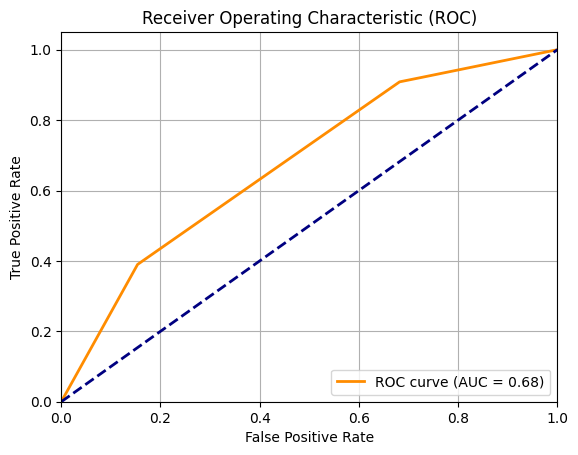

Tree depth 4
min_samples_leaf 12
goal                     0.540420
category_grouped_Web     0.247963
create_to_launch_days    0.211617
dtype: float64
Cross-validation scores: [0.51501938 0.59253876 0.70867668 0.79301987 0.63305865 0.70431411
 0.6980126  0.71013088 0.70964615 0.68880271]
Mean accuracy: 0.6753
Standard deviation of accuracy: 0.0730


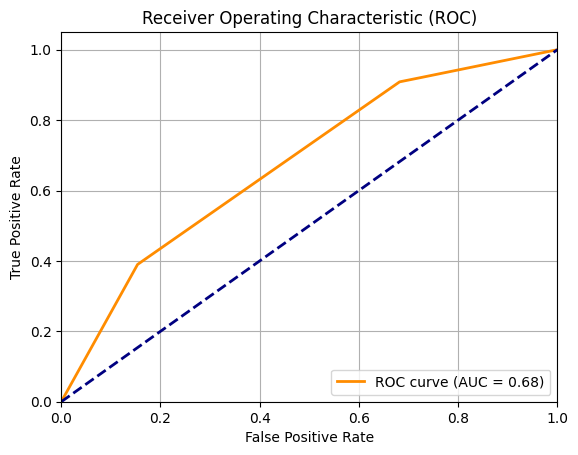

Tree depth 4
min_samples_leaf 13
goal                     0.540420
category_grouped_Web     0.247963
create_to_launch_days    0.211617
dtype: float64
Cross-validation scores: [0.51501938 0.59253876 0.70867668 0.79301987 0.63305865 0.70431411
 0.6980126  0.71013088 0.70964615 0.68880271]
Mean accuracy: 0.6753
Standard deviation of accuracy: 0.0730


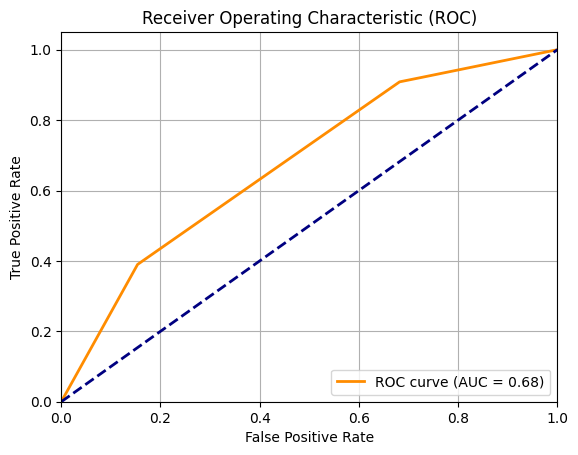

Tree depth 4
min_samples_leaf 14
goal                     0.540420
category_grouped_Web     0.247963
create_to_launch_days    0.211617
dtype: float64
Cross-validation scores: [0.51501938 0.59253876 0.70867668 0.79301987 0.63305865 0.70431411
 0.6980126  0.71013088 0.70964615 0.68880271]
Mean accuracy: 0.6753
Standard deviation of accuracy: 0.0730


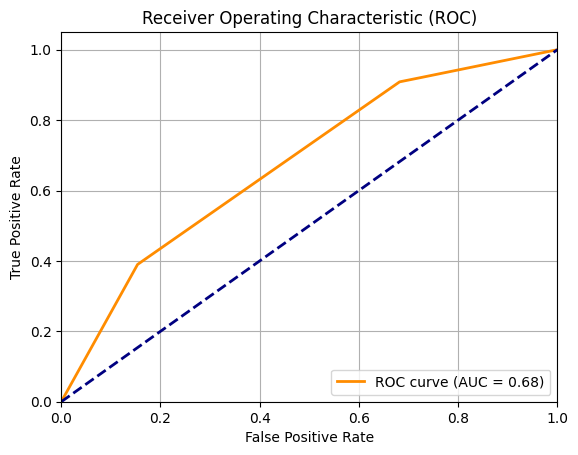

Tree depth 4
min_samples_leaf 2
goal                           0.400631
launch_to_state_change_days    0.243322
category_grouped_Web           0.180496
create_to_launch_days          0.154039
launched_at_yr                 0.021513
dtype: float64
Cross-validation scores: [0.47771318 0.58963178 0.70867668 0.52399418 0.64372273 0.71740184
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6516
Standard deviation of accuracy: 0.0859


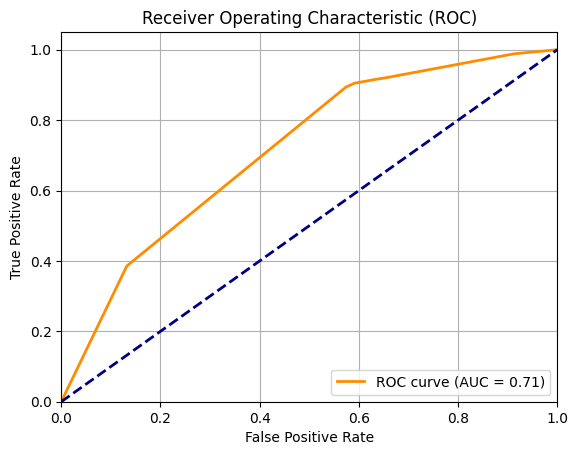

Tree depth 4
min_samples_leaf 3
goal                           0.400631
launch_to_state_change_days    0.243322
category_grouped_Web           0.180496
create_to_launch_days          0.154039
launched_at_yr                 0.021513
dtype: float64
Cross-validation scores: [0.47771318 0.58963178 0.70867668 0.52399418 0.64372273 0.71740184
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6516
Standard deviation of accuracy: 0.0859


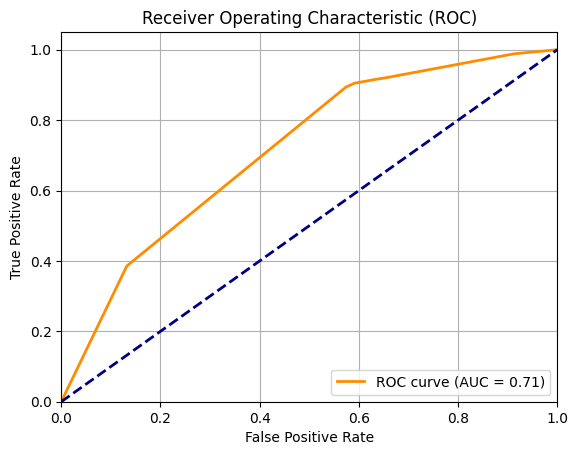

Tree depth 4
min_samples_leaf 4
goal                           0.400631
launch_to_state_change_days    0.243322
category_grouped_Web           0.180496
create_to_launch_days          0.154039
launched_at_yr                 0.021513
dtype: float64
Cross-validation scores: [0.47771318 0.58963178 0.70867668 0.52399418 0.64372273 0.71740184
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6516
Standard deviation of accuracy: 0.0859


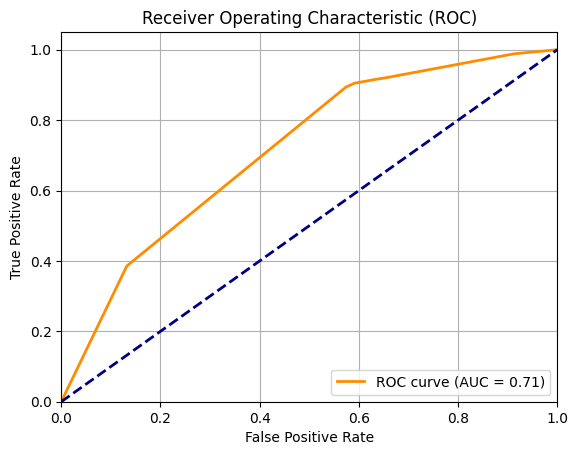

Tree depth 4
min_samples_leaf 5
goal                           0.400631
launch_to_state_change_days    0.243322
category_grouped_Web           0.180496
create_to_launch_days          0.154039
launched_at_yr                 0.021513
dtype: float64
Cross-validation scores: [0.47771318 0.58963178 0.70867668 0.52399418 0.64372273 0.71740184
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6516
Standard deviation of accuracy: 0.0859


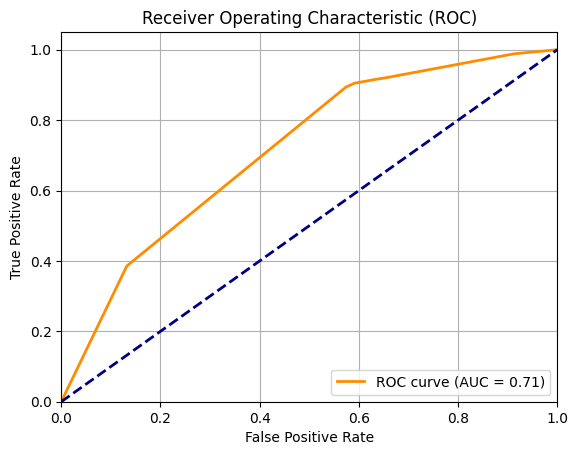

Tree depth 4
min_samples_leaf 6
goal                           0.400631
launch_to_state_change_days    0.243322
category_grouped_Web           0.180496
create_to_launch_days          0.154039
launched_at_yr                 0.021513
dtype: float64
Cross-validation scores: [0.47771318 0.58963178 0.70867668 0.52399418 0.64372273 0.71740184
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6516
Standard deviation of accuracy: 0.0859


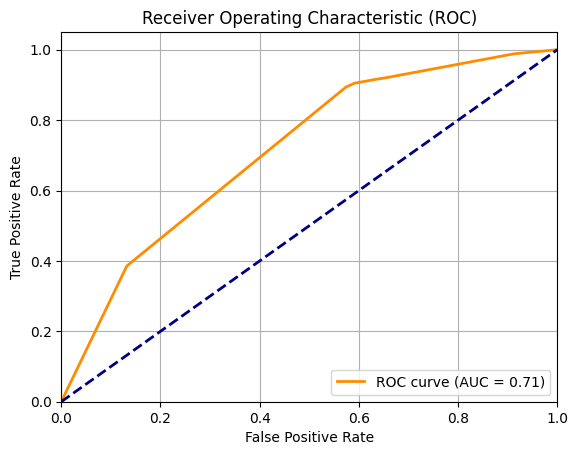

Tree depth 4
min_samples_leaf 7
goal                           0.400631
launch_to_state_change_days    0.243322
category_grouped_Web           0.180496
create_to_launch_days          0.154039
launched_at_yr                 0.021513
dtype: float64
Cross-validation scores: [0.47771318 0.58963178 0.70867668 0.52399418 0.64372273 0.71740184
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6516
Standard deviation of accuracy: 0.0859


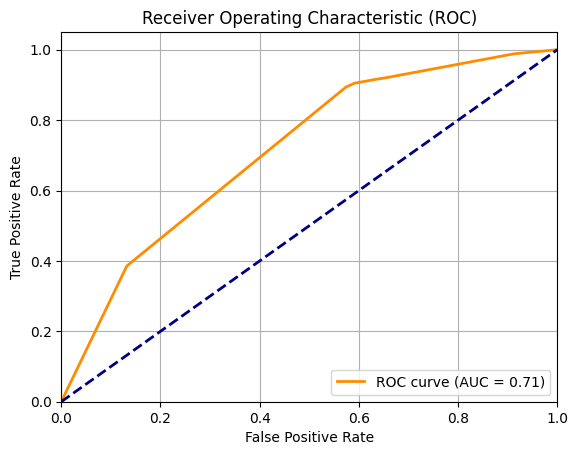

Tree depth 4
min_samples_leaf 8
goal                           0.400631
launch_to_state_change_days    0.243322
category_grouped_Web           0.180496
create_to_launch_days          0.154039
launched_at_yr                 0.021513
dtype: float64
Cross-validation scores: [0.47771318 0.58963178 0.70867668 0.52399418 0.64372273 0.71740184
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6516
Standard deviation of accuracy: 0.0859


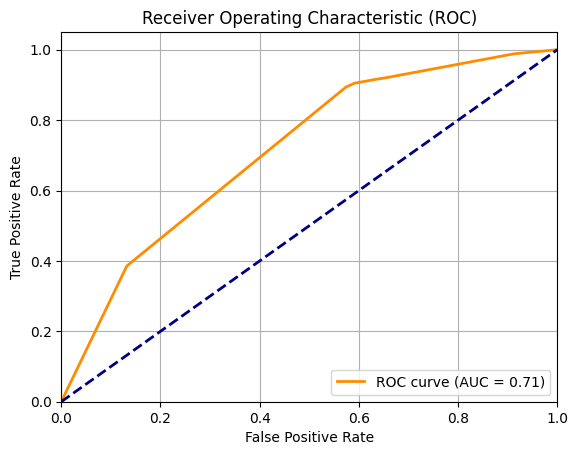

Tree depth 4
min_samples_leaf 9
goal                           0.400631
launch_to_state_change_days    0.243322
category_grouped_Web           0.180496
create_to_launch_days          0.154039
launched_at_yr                 0.021513
dtype: float64
Cross-validation scores: [0.47771318 0.58963178 0.70867668 0.52399418 0.64372273 0.71740184
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6516
Standard deviation of accuracy: 0.0859


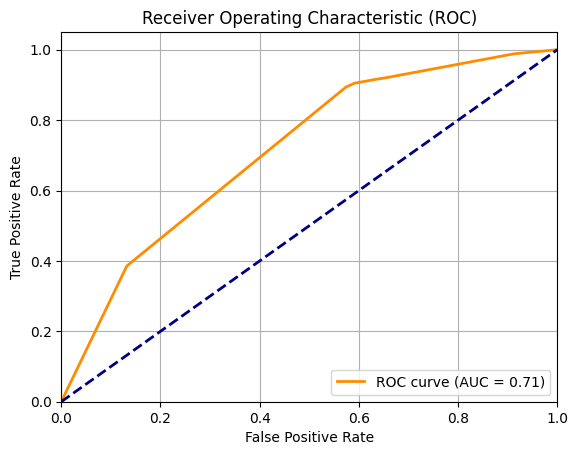

Tree depth 4
min_samples_leaf 10
goal                           0.400631
launch_to_state_change_days    0.243322
category_grouped_Web           0.180496
create_to_launch_days          0.154039
launched_at_yr                 0.021513
dtype: float64
Cross-validation scores: [0.47771318 0.58963178 0.70867668 0.52399418 0.64372273 0.71740184
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6516
Standard deviation of accuracy: 0.0859


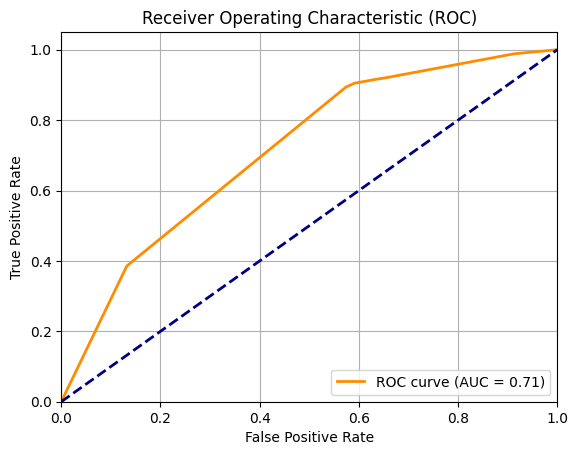

Tree depth 4
min_samples_leaf 11
goal                           0.400631
launch_to_state_change_days    0.243322
category_grouped_Web           0.180496
create_to_launch_days          0.154039
launched_at_yr                 0.021513
dtype: float64
Cross-validation scores: [0.47771318 0.58963178 0.70867668 0.52399418 0.64372273 0.71740184
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6516
Standard deviation of accuracy: 0.0859


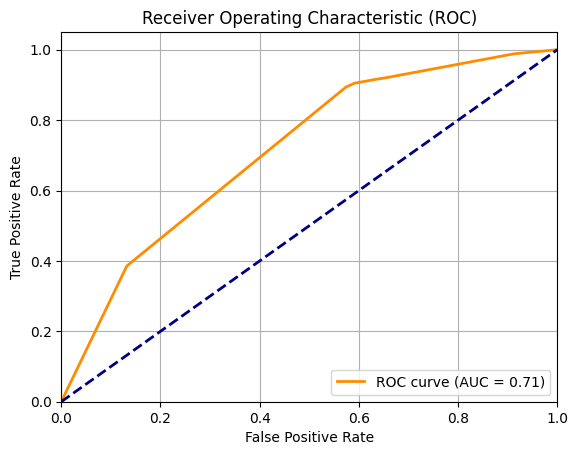

Tree depth 4
min_samples_leaf 12
goal                           0.400631
launch_to_state_change_days    0.243322
category_grouped_Web           0.180496
create_to_launch_days          0.154039
launched_at_yr                 0.021513
dtype: float64
Cross-validation scores: [0.47771318 0.58963178 0.70867668 0.52399418 0.64372273 0.71740184
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6516
Standard deviation of accuracy: 0.0859


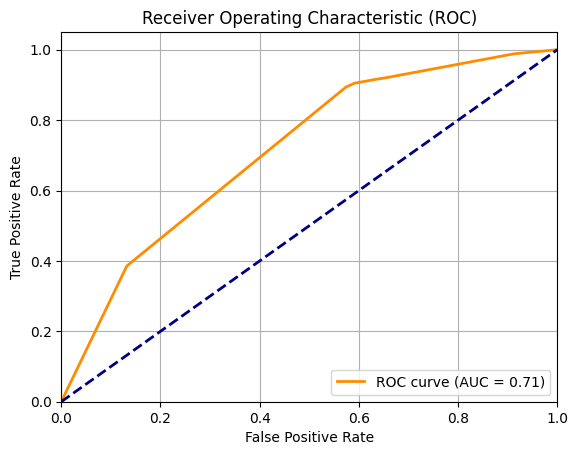

Tree depth 4
min_samples_leaf 13
goal                           0.400631
launch_to_state_change_days    0.243322
category_grouped_Web           0.180496
create_to_launch_days          0.154039
launched_at_yr                 0.021513
dtype: float64
Cross-validation scores: [0.47771318 0.58963178 0.70867668 0.52399418 0.64372273 0.71740184
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6516
Standard deviation of accuracy: 0.0859


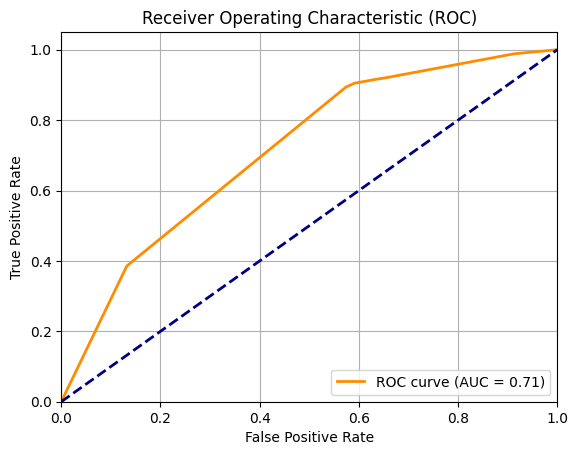

Tree depth 4
min_samples_leaf 14
goal                           0.400631
launch_to_state_change_days    0.243322
category_grouped_Web           0.180496
create_to_launch_days          0.154039
launched_at_yr                 0.021513
dtype: float64
Cross-validation scores: [0.47771318 0.58963178 0.70867668 0.52399418 0.64372273 0.71740184
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6516
Standard deviation of accuracy: 0.0859


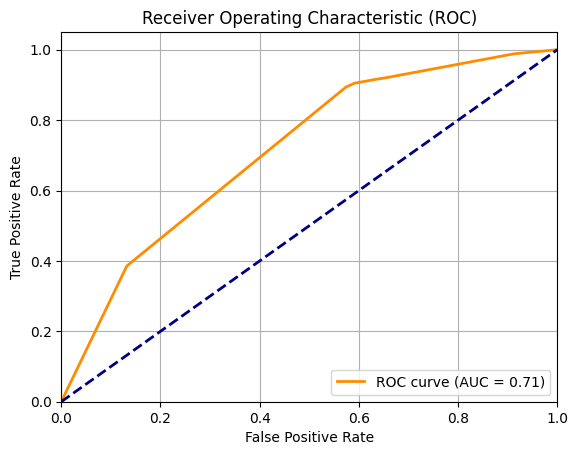

Tree depth 4
min_samples_leaf 2
goal                           0.328978
category_grouped_Web           0.229200
launch_to_state_change_days    0.193853
create_to_launch_days          0.127179
category_grouped_Software      0.073815
launch_to_deadline_days        0.025930
launched_at_yr                 0.017139
created_at_hr                  0.003905
dtype: float64
Cross-validation scores: [0.49031008 0.57848837 0.7401842  0.52399418 0.64517693 0.74503151
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6578
Standard deviation of accuracy: 0.0893


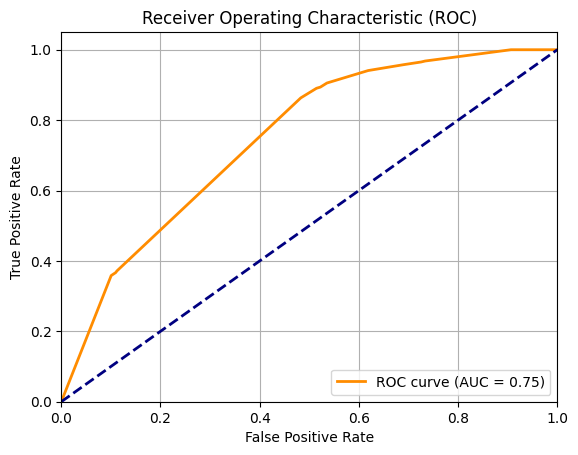

Tree depth 4
min_samples_leaf 3
goal                           0.328978
category_grouped_Web           0.229200
launch_to_state_change_days    0.193853
create_to_launch_days          0.127179
category_grouped_Software      0.073815
launch_to_deadline_days        0.025930
launched_at_yr                 0.017139
created_at_hr                  0.003905
dtype: float64
Cross-validation scores: [0.49031008 0.57848837 0.7401842  0.52399418 0.64517693 0.74503151
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6578
Standard deviation of accuracy: 0.0893


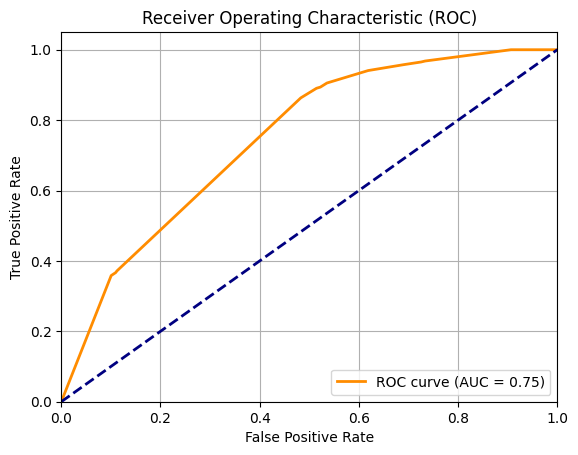

Tree depth 4
min_samples_leaf 4
goal                           0.328978
category_grouped_Web           0.229200
launch_to_state_change_days    0.193853
create_to_launch_days          0.127179
category_grouped_Software      0.073815
launch_to_deadline_days        0.025930
launched_at_yr                 0.017139
created_at_hr                  0.003905
dtype: float64
Cross-validation scores: [0.49031008 0.57848837 0.7401842  0.52399418 0.64517693 0.74503151
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6578
Standard deviation of accuracy: 0.0893


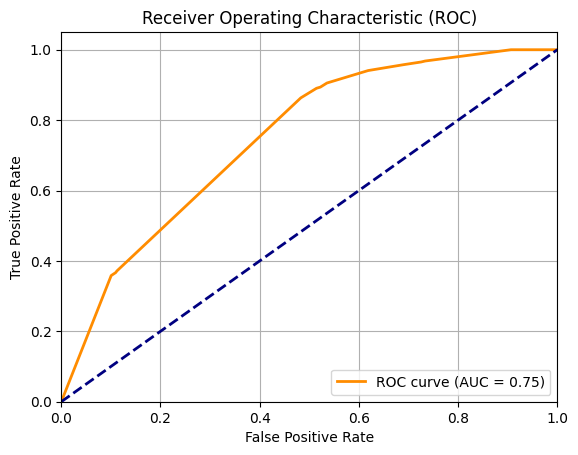

Tree depth 4
min_samples_leaf 5
goal                           0.328978
category_grouped_Web           0.229200
launch_to_state_change_days    0.193853
create_to_launch_days          0.127179
category_grouped_Software      0.073815
launch_to_deadline_days        0.025930
launched_at_yr                 0.017139
created_at_hr                  0.003905
dtype: float64
Cross-validation scores: [0.49031008 0.57848837 0.7401842  0.52399418 0.64517693 0.74503151
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6578
Standard deviation of accuracy: 0.0893


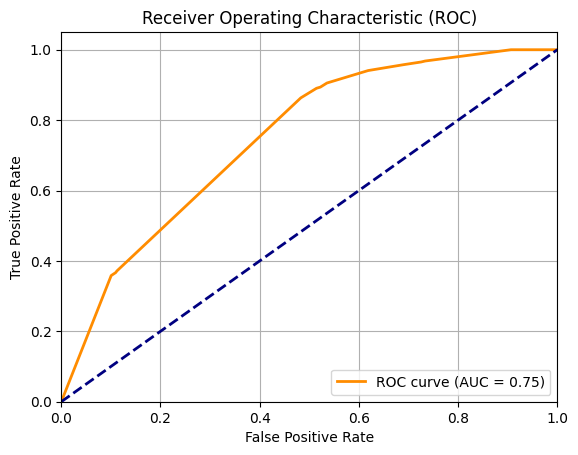

Tree depth 4
min_samples_leaf 6
goal                           0.328978
category_grouped_Web           0.229200
launch_to_state_change_days    0.193853
create_to_launch_days          0.127179
category_grouped_Software      0.073815
launch_to_deadline_days        0.025930
launched_at_yr                 0.017139
created_at_hr                  0.003905
dtype: float64
Cross-validation scores: [0.49031008 0.57848837 0.7401842  0.52399418 0.64517693 0.74503151
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6578
Standard deviation of accuracy: 0.0893


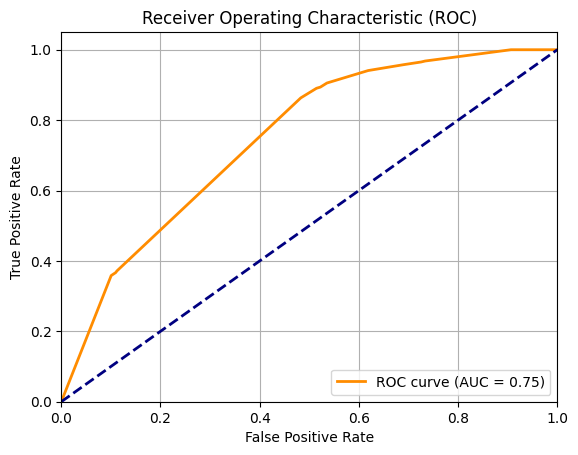

Tree depth 4
min_samples_leaf 7
goal                           0.329431
category_grouped_Web           0.229515
launch_to_state_change_days    0.194120
create_to_launch_days          0.127354
category_grouped_Software      0.073917
launch_to_deadline_days        0.025966
launched_at_yr                 0.017163
created_at_hr                  0.002533
dtype: float64
Cross-validation scores: [0.49031008 0.57848837 0.7401842  0.52399418 0.64517693 0.74503151
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6578
Standard deviation of accuracy: 0.0893


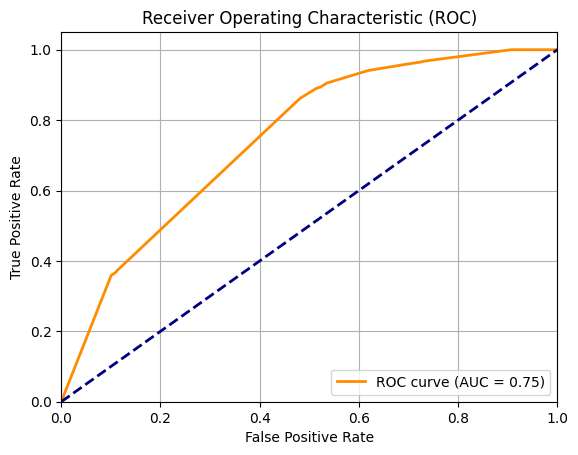

Tree depth 4
min_samples_leaf 8
goal                           0.329702
category_grouped_Web           0.229704
launch_to_state_change_days    0.194279
create_to_launch_days          0.129172
category_grouped_Software      0.073978
launch_to_deadline_days        0.025988
launched_at_yr                 0.017177
dtype: float64
Cross-validation scores: [0.49031008 0.57848837 0.7401842  0.52399418 0.64517693 0.74503151
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6578
Standard deviation of accuracy: 0.0893


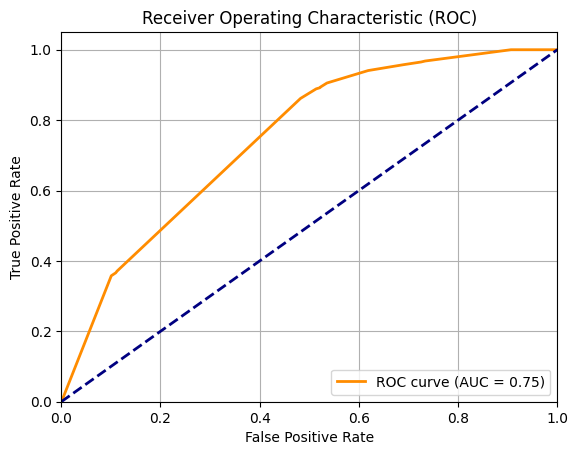

Tree depth 4
min_samples_leaf 9
goal                           0.329702
category_grouped_Web           0.229704
launch_to_state_change_days    0.194279
create_to_launch_days          0.129172
category_grouped_Software      0.073978
launch_to_deadline_days        0.025988
launched_at_yr                 0.017177
dtype: float64
Cross-validation scores: [0.49031008 0.57848837 0.7401842  0.52399418 0.64517693 0.74503151
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6578
Standard deviation of accuracy: 0.0893


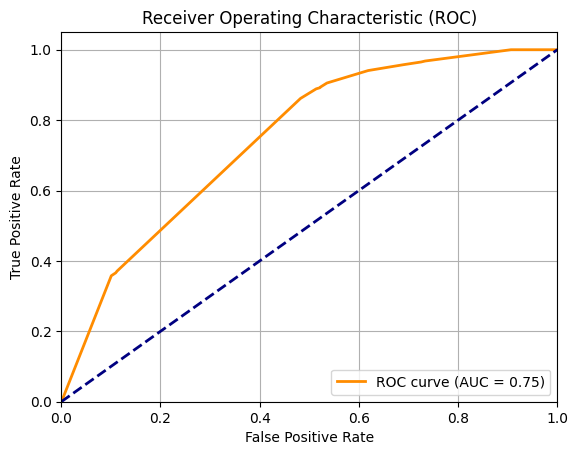

Tree depth 4
min_samples_leaf 10
goal                           0.329941
category_grouped_Web           0.229870
launch_to_state_change_days    0.194420
create_to_launch_days          0.128542
category_grouped_Software      0.074031
launch_to_deadline_days        0.026006
launched_at_yr                 0.017189
dtype: float64
Cross-validation scores: [0.49031008 0.57848837 0.7401842  0.52399418 0.64517693 0.74503151
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6578
Standard deviation of accuracy: 0.0893


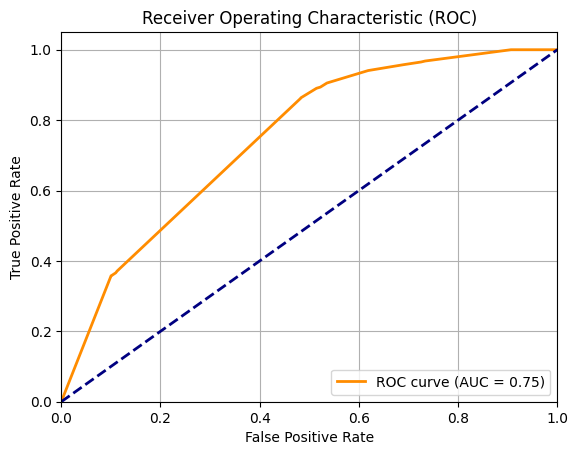

Tree depth 4
min_samples_leaf 11
goal                           0.329967
category_grouped_Web           0.229889
launch_to_state_change_days    0.194436
create_to_launch_days          0.128472
category_grouped_Software      0.074037
launch_to_deadline_days        0.026008
launched_at_yr                 0.017191
dtype: float64
Cross-validation scores: [0.49031008 0.57848837 0.7401842  0.52399418 0.64517693 0.74503151
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6578
Standard deviation of accuracy: 0.0893


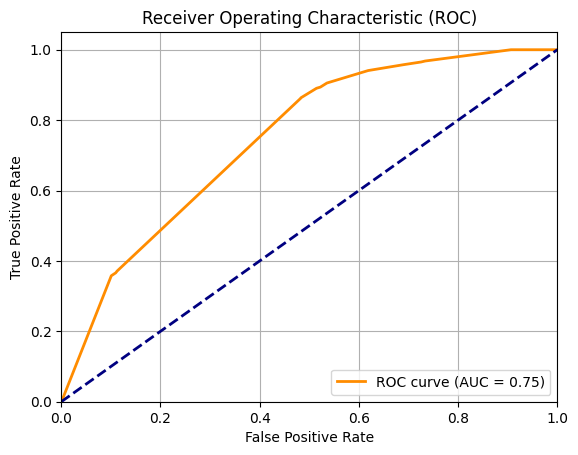

Tree depth 4
min_samples_leaf 12
goal                           0.329967
category_grouped_Web           0.229889
launch_to_state_change_days    0.194436
create_to_launch_days          0.128472
category_grouped_Software      0.074037
launch_to_deadline_days        0.026008
launched_at_yr                 0.017191
dtype: float64
Cross-validation scores: [0.49031008 0.57848837 0.7401842  0.52399418 0.64517693 0.74503151
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6578
Standard deviation of accuracy: 0.0893


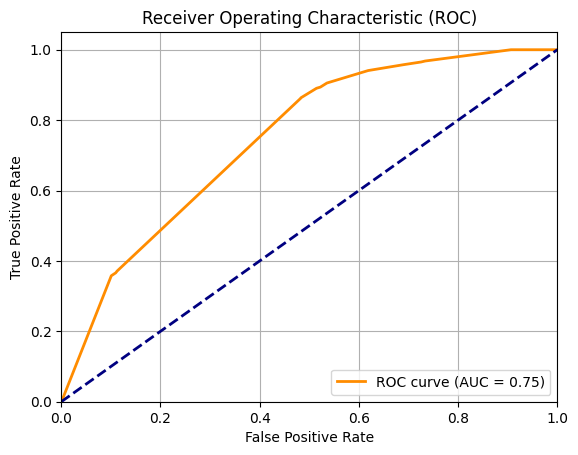

Tree depth 4
min_samples_leaf 13
goal                           0.330268
category_grouped_Web           0.230098
launch_to_state_change_days    0.194613
create_to_launch_days          0.127677
category_grouped_Software      0.074105
launch_to_deadline_days        0.026032
launched_at_yr                 0.017206
dtype: float64
Cross-validation scores: [0.49031008 0.57848837 0.7401842  0.52399418 0.64517693 0.74503151
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6578
Standard deviation of accuracy: 0.0893


Tree depth 4
min_samples_leaf 14
goal                           0.330268
category_grouped_Web           0.230098
launch_to_state_change_days    0.194613
create_to_launch_days          0.127677
category_grouped_Software      0.074105
launch_to_deadline_days        0.026032
launched_at_yr                 0.017206
dtype: float64
Cross-validation scores: [0.49031008 0.57848837 0.7401842  0.52399418 0.64517693 0.74503151
 0.70528357 0.71788657 0.72758119 0.70382937]
Mean accuracy: 0.6578
Standard deviation of accuracy: 0.0893


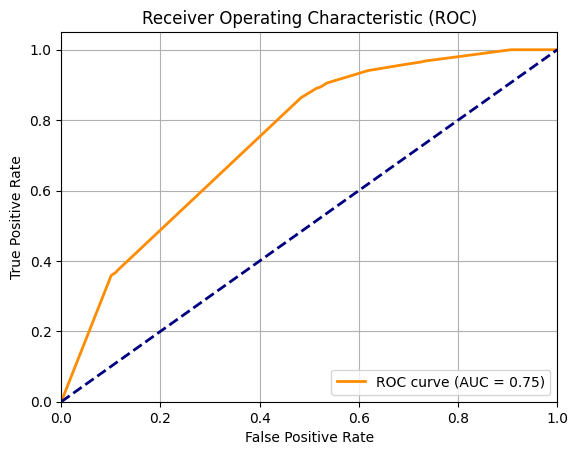

Tree depth 4
min_samples_leaf 2
goal                           0.282936
category_grouped_Web           0.205496
launch_to_state_change_days    0.166722
category_grouped_Software      0.119868
create_to_launch_days          0.112095
canceled                       0.038779
launch_to_deadline_days        0.024170
launched_at_yr                 0.014741
category_grouped_Hardware      0.011552
deadline_day                   0.005285
new                            0.005096
static_usd_rate                0.004634
launched_at_day                0.003654
created_at_hr                  0.003359
launched_at_hr                 0.001611
dtype: float64
Cross-validation scores: [0.49031008 0.57751938 0.7401842  0.52641784 0.6446922  0.74503151
 0.57828405 0.72418808 0.73339796 0.70722249]
Mean accuracy: 0.6467
Standard deviation of accuracy: 0.0916


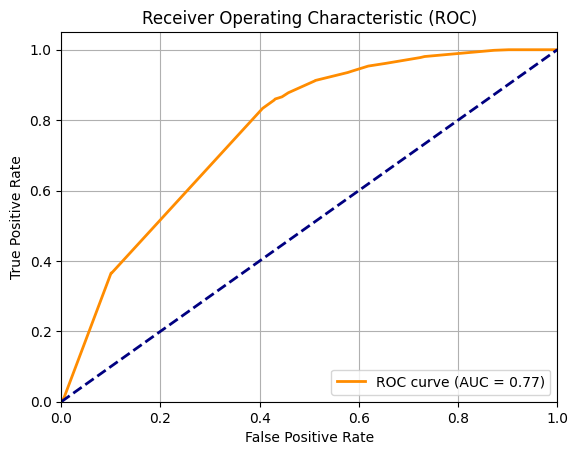

Tree depth 4
min_samples_leaf 3
goal                           0.282936
category_grouped_Web           0.205496
launch_to_state_change_days    0.166722
category_grouped_Software      0.119868
create_to_launch_days          0.112095
canceled                       0.038779
launch_to_deadline_days        0.024170
launched_at_yr                 0.014741
category_grouped_Hardware      0.011552
deadline_day                   0.005285
new                            0.005096
static_usd_rate                0.004634
launched_at_day                0.003654
created_at_hr                  0.003359
launched_at_hr                 0.001611
dtype: float64
Cross-validation scores: [0.49031008 0.57606589 0.7401842  0.52641784 0.6446922  0.74503151
 0.57828405 0.72418808 0.73339796 0.70722249]
Mean accuracy: 0.6466
Standard deviation of accuracy: 0.0918


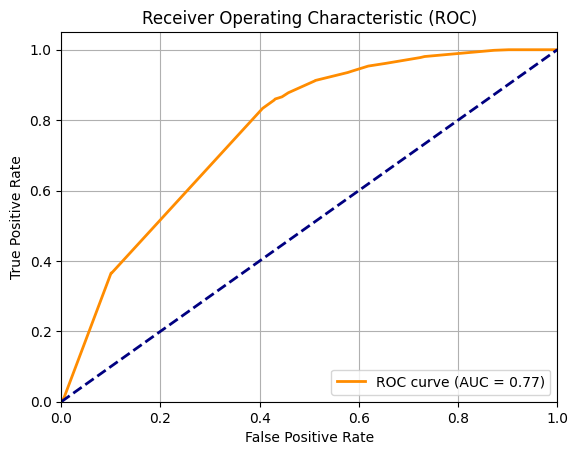

Tree depth 4
min_samples_leaf 4
goal                           0.283189
category_grouped_Web           0.205680
launch_to_state_change_days    0.168046
category_grouped_Software      0.119975
create_to_launch_days          0.112195
canceled                       0.038814
launch_to_deadline_days        0.024192
launched_at_yr                 0.014754
category_grouped_Hardware      0.011563
created_at_hr                  0.005531
new                            0.005101
static_usd_rate                0.004639
launched_at_day                0.003658
deadline_day                   0.002664
dtype: float64
Cross-validation scores: [0.49031008 0.57848837 0.7401842  0.52641784 0.6446922  0.74503151
 0.57828405 0.72418808 0.7338827  0.70722249]
Mean accuracy: 0.6469
Standard deviation of accuracy: 0.0916


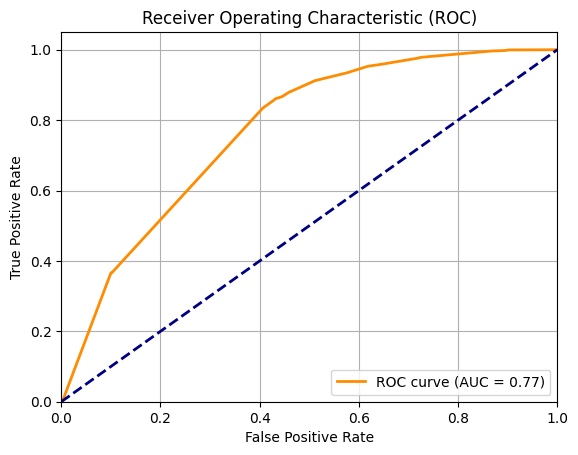

Tree depth 4
min_samples_leaf 5
goal                           0.283396
category_grouped_Web           0.205830
launch_to_state_change_days    0.168169
category_grouped_Software      0.120063
create_to_launch_days          0.112277
canceled                       0.038842
launch_to_deadline_days        0.024210
launched_at_yr                 0.018502
category_grouped_Hardware      0.011571
created_at_hr                  0.005536
static_usd_rate                0.004642
created_at_month               0.003135
deadline_day                   0.002665
new                            0.001163
dtype: float64
Cross-validation scores: [0.49031008 0.57848837 0.7401842  0.52641784 0.6446922  0.74503151
 0.57828405 0.72418808 0.7338827  0.70722249]
Mean accuracy: 0.6469
Standard deviation of accuracy: 0.0916


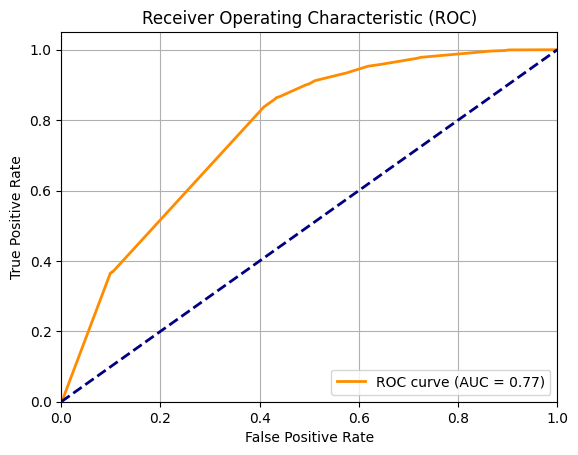

Tree depth 4
min_samples_leaf 6
goal                           0.283396
category_grouped_Web           0.205830
launch_to_state_change_days    0.168169
category_grouped_Software      0.120063
create_to_launch_days          0.112277
canceled                       0.038842
launch_to_deadline_days        0.024210
launched_at_yr                 0.018502
category_grouped_Hardware      0.011571
created_at_hr                  0.005536
static_usd_rate                0.004642
created_at_month               0.003135
deadline_day                   0.002665
new                            0.001163
dtype: float64
Cross-validation scores: [0.49031008 0.57848837 0.7401842  0.52641784 0.6446922  0.74503151
 0.57828405 0.72418808 0.7338827  0.70722249]
Mean accuracy: 0.6469
Standard deviation of accuracy: 0.0916


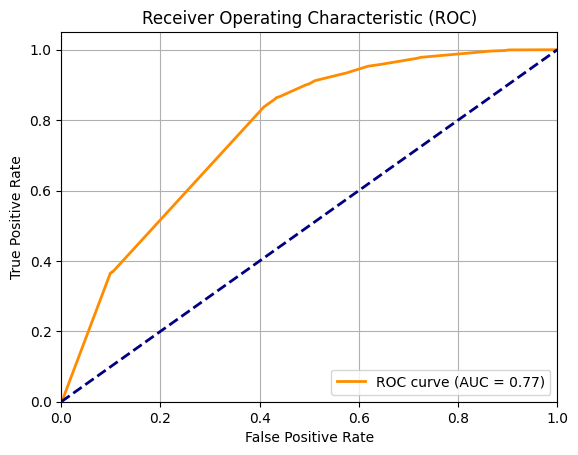

Tree depth 4
min_samples_leaf 7
goal                           0.283779
category_grouped_Web           0.206108
launch_to_state_change_days    0.168396
category_grouped_Software      0.120225
create_to_launch_days          0.112429
canceled                       0.038895
launch_to_deadline_days        0.024242
launched_at_yr                 0.018527
category_grouped_Hardware      0.011587
static_usd_rate                0.004648
created_at_hr                  0.004190
created_at_month               0.003140
deadline_day                   0.002669
new                            0.001165
dtype: float64
Cross-validation scores: [0.49031008 0.57848837 0.7401842  0.52641784 0.6446922  0.74503151
 0.57828405 0.72418808 0.73339796 0.70722249]
Mean accuracy: 0.6468
Standard deviation of accuracy: 0.0916


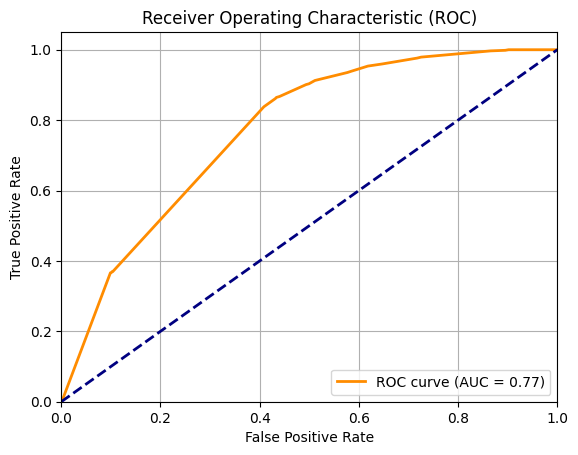

Tree depth 4
min_samples_leaf 8
goal                           0.284439
category_grouped_Web           0.206588
launch_to_state_change_days    0.168788
category_grouped_Software      0.120505
create_to_launch_days          0.114168
canceled                       0.038985
launch_to_deadline_days        0.024299
launched_at_yr                 0.018570
category_grouped_Hardware      0.011614
static_usd_rate                0.004659
created_at_month               0.003147
deadline_day                   0.002675
new                            0.001168
country_grouped_US             0.000395
dtype: float64
Cross-validation scores: [0.49031008 0.57848837 0.7401842  0.52641784 0.6446922  0.74503151
 0.57828405 0.72418808 0.73339796 0.70722249]
Mean accuracy: 0.6468
Standard deviation of accuracy: 0.0916


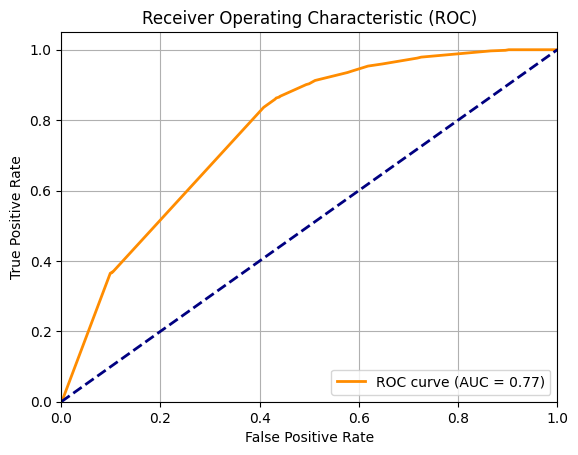

Tree depth 4
min_samples_leaf 9
goal                           0.284606
category_grouped_Web           0.206709
launch_to_state_change_days    0.168887
category_grouped_Software      0.120576
create_to_launch_days          0.114236
canceled                       0.039008
launch_to_deadline_days        0.024313
launched_at_yr                 0.018581
category_grouped_Hardware      0.011621
static_usd_rate                0.004662
created_at_month               0.003149
deadline_day                   0.002677
new                            0.000976
dtype: float64
Cross-validation scores: [0.49031008 0.59108527 0.7401842  0.52641784 0.6446922  0.74503151
 0.57828405 0.72418808 0.73339796 0.70722249]
Mean accuracy: 0.6481
Standard deviation of accuracy: 0.0907


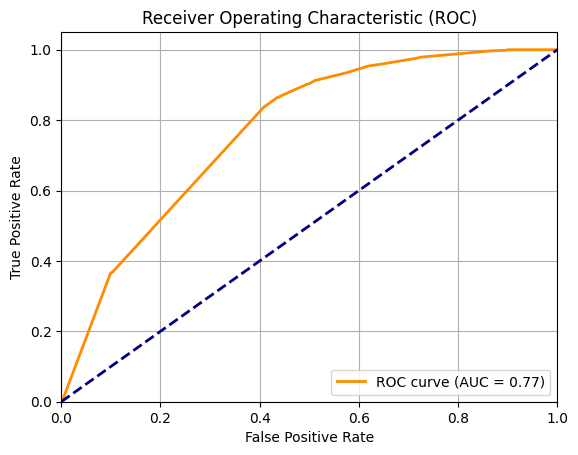

Tree depth 4
min_samples_leaf 10
goal                           0.284989
category_grouped_Web           0.206987
launch_to_state_change_days    0.169114
category_grouped_Software      0.120738
create_to_launch_days          0.113764
canceled                       0.039061
launch_to_deadline_days        0.024346
launched_at_yr                 0.018606
category_grouped_Hardware      0.011636
static_usd_rate                0.004668
created_at_month               0.003153
launched_at_day                0.002114
new                            0.000825
dtype: float64
Cross-validation scores: [0.49031008 0.59108527 0.7401842  0.52641784 0.6446922  0.74503151
 0.57828405 0.72418808 0.73339796 0.70722249]
Mean accuracy: 0.6481
Standard deviation of accuracy: 0.0907


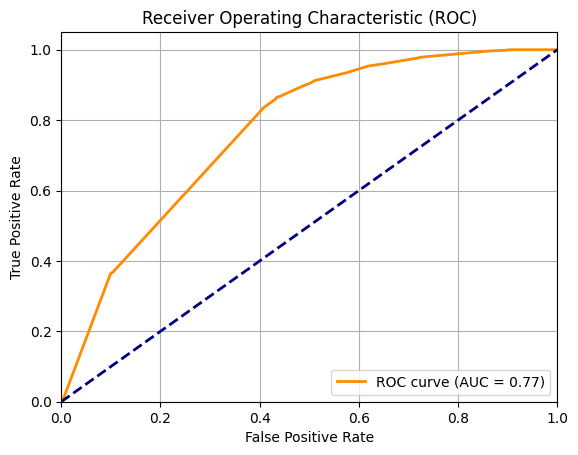

Tree depth 4
min_samples_leaf 11
goal                           0.285064
category_grouped_Web           0.207041
launch_to_state_change_days    0.169791
category_grouped_Software      0.120769
create_to_launch_days          0.113725
canceled                       0.039071
launch_to_deadline_days        0.024352
launched_at_yr                 0.018610
category_grouped_Hardware      0.011639
static_usd_rate                0.004669
created_at_month               0.003154
launched_at_day                0.002114
dtype: float64
Cross-validation scores: [0.49031008 0.59108527 0.7401842  0.52641784 0.6446922  0.74503151
 0.57828405 0.72418808 0.73339796 0.70722249]
Mean accuracy: 0.6481
Standard deviation of accuracy: 0.0907


Tree depth 4
min_samples_leaf 12
goal                           0.285064
category_grouped_Web           0.207041
launch_to_state_change_days    0.169791
category_grouped_Software      0.120769
create_to_launch_days          0.113725
canceled                       0.039071
launch_to_deadline_days        0.024352
launched_at_yr                 0.018610
category_grouped_Hardware      0.011639
static_usd_rate                0.004669
created_at_month               0.003154
launched_at_day                0.002114
dtype: float64
Cross-validation scores: [0.48982558 0.58817829 0.7401842  0.52641784 0.64420746 0.74503151
 0.57828405 0.72418808 0.73339796 0.70722249]
Mean accuracy: 0.6477
Standard deviation of accuracy: 0.0910


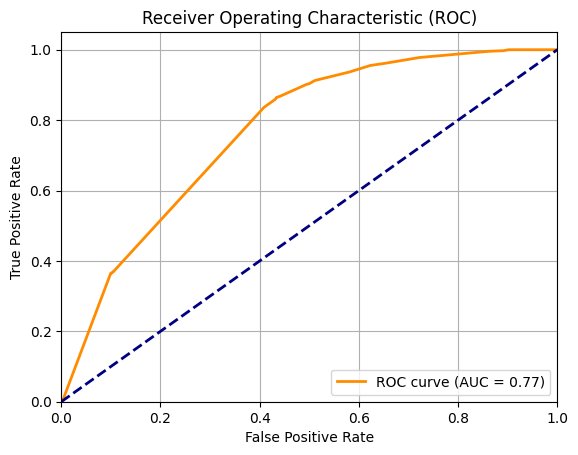

Tree depth 4
min_samples_leaf 13
goal                           0.285288
category_grouped_Web           0.207204
launch_to_state_change_days    0.169925
category_grouped_Software      0.120864
create_to_launch_days          0.113027
canceled                       0.039102
launch_to_deadline_days        0.024371
launched_at_yr                 0.018625
category_grouped_Hardware      0.011648
static_usd_rate                0.004673
created_at_month               0.003156
launched_at_day                0.002116
dtype: float64
Cross-validation scores: [0.48982558 0.58817829 0.7401842  0.52641784 0.64420746 0.74503151
 0.57828405 0.72418808 0.73339796 0.70722249]
Mean accuracy: 0.6477
Standard deviation of accuracy: 0.0910


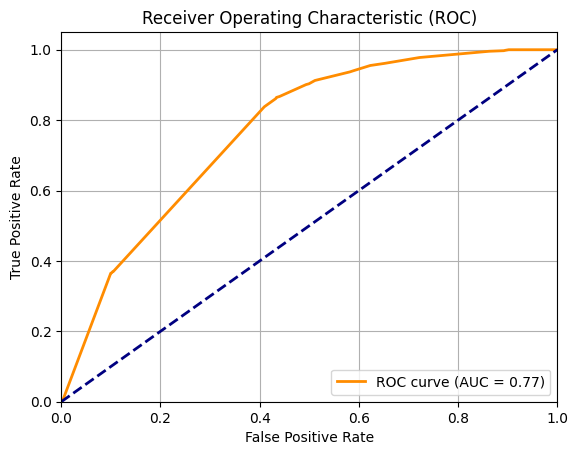

Tree depth 4
min_samples_leaf 14
goal                           0.287127
category_grouped_Web           0.207218
launch_to_state_change_days    0.169936
category_grouped_Software      0.120872
create_to_launch_days          0.113034
canceled                       0.039104
launch_to_deadline_days        0.022488
launched_at_yr                 0.018626
category_grouped_Hardware      0.011649
static_usd_rate                0.004673
created_at_month               0.003157
launched_at_day                0.002116
dtype: float64
Cross-validation scores: [0.48982558 0.58914729 0.7401842  0.52641784 0.64420746 0.74454678
 0.57828405 0.72418808 0.73339796 0.70770722]
Mean accuracy: 0.6478
Standard deviation of accuracy: 0.0909


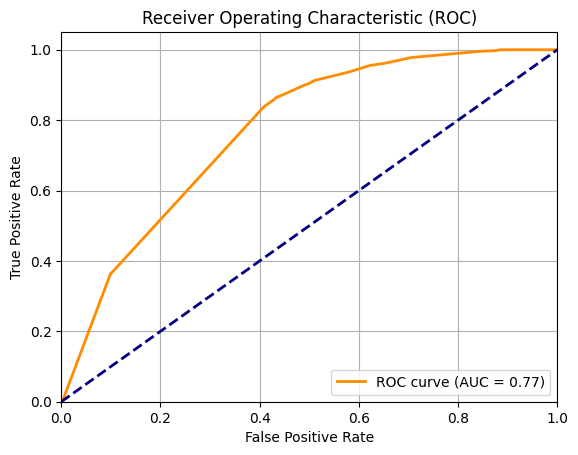

Tree depth 4
min_samples_leaf 2
goal                           0.300824
category_grouped_Web           0.183520
launch_to_state_change_days    0.155561
create_to_launch_days          0.119730
category_grouped_Software      0.107049
canceled                       0.034632
launch_to_deadline_days        0.026067
launched_at_yr                 0.015720
category_grouped_Hardware      0.010317
help                           0.008533
static_usd_rate                0.008465
new                            0.007843
created_at_month               0.005557
launched_at_day                0.005002
deadline_day                   0.004720
launched_at_hr                 0.003460
created_at_hr                  0.002999
dtype: float64
Cross-validation scores: [0.49515504 0.59156977 0.74163839 0.49878817 0.68201648 0.74454678
 0.57876878 0.72418808 0.7324285  0.70770722]
Mean accuracy: 0.6497
Standard deviation of accuracy: 0.0945


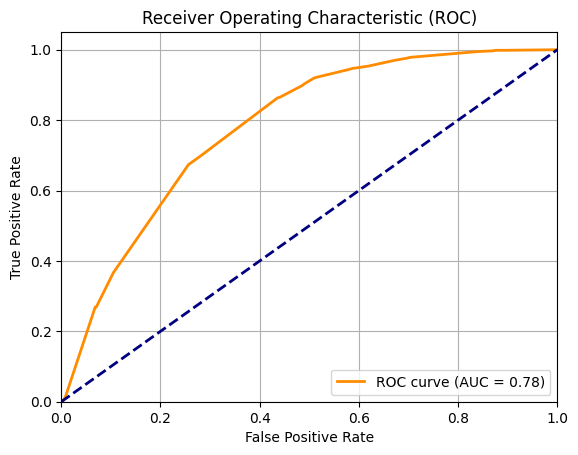

Tree depth 4
min_samples_leaf 3
goal                           0.302346
category_grouped_Web           0.183694
launch_to_state_change_days    0.155708
create_to_launch_days          0.119843
category_grouped_Software      0.107151
canceled                       0.034665
launch_to_deadline_days        0.026091
launched_at_yr                 0.015735
category_grouped_Hardware      0.010327
help                           0.008541
static_usd_rate                0.007916
new                            0.007850
launched_at_day                0.005007
deadline_day                   0.004724
launched_at_hr                 0.003463
created_at_month               0.003386
created_at_hr                  0.003002
created_at_weekday_Tuesday     0.000549
dtype: float64
Cross-validation scores: [0.49515504 0.59011628 0.74163839 0.49878817 0.68201648 0.74406205
 0.57876878 0.72418808 0.7324285  0.70770722]
Mean accuracy: 0.6495
Standard deviation of accuracy: 0.0946


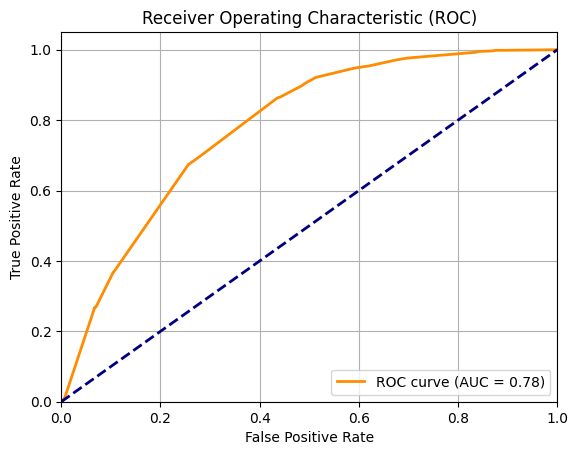

Tree depth 4
min_samples_leaf 4
goal                           0.302072
category_grouped_Web           0.183528
launch_to_state_change_days    0.157252
create_to_launch_days          0.120072
category_grouped_Software      0.107054
canceled                       0.034634
launch_to_deadline_days        0.027700
launched_at_yr                 0.015721
category_grouped_Hardware      0.010317
help                           0.008534
static_usd_rate                0.007908
new                            0.007843
created_at_hr                  0.004936
created_at_month               0.003383
launched_at_day                0.003264
deadline_day                   0.002377
launched_at_hr                 0.002022
deadline_month                 0.000835
created_at_weekday_Tuesday     0.000549
dtype: float64
Cross-validation scores: [0.49515504 0.59447674 0.74163839 0.49878817 0.68250121 0.74357731
 0.57876878 0.72418808 0.73339796 0.70770722]
Mean accuracy: 0.6500
Standard deviation of accuracy: 0

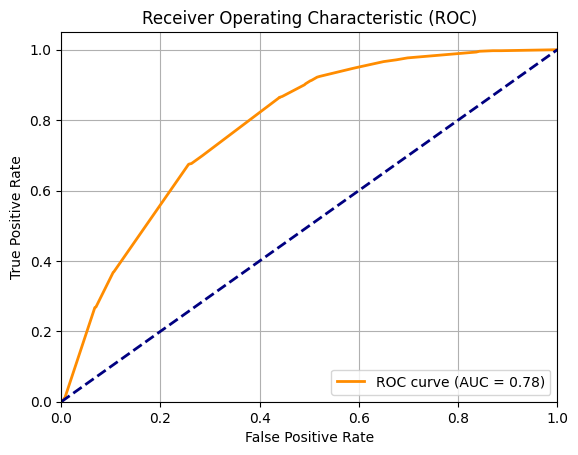

Tree depth 4
min_samples_leaf 5
goal                           0.301510
category_grouped_Web           0.183661
launch_to_state_change_days    0.155785
create_to_launch_days          0.120089
category_grouped_Software      0.110155
canceled                       0.034659
launch_to_deadline_days        0.029949
launched_at_yr                 0.016509
category_grouped_Hardware      0.010325
help                           0.008540
static_usd_rate                0.007914
created_at_hr                  0.004939
new                            0.003412
created_at_month               0.002798
deadline_day                   0.002378
launched_at_day                0.002047
launched_at_hr                 0.002023
created_at_day                 0.001923
deadline_month                 0.000835
created_at_weekday_Tuesday     0.000549
dtype: float64
Cross-validation scores: [0.49515504 0.59593023 0.74163839 0.49878817 0.68201648 0.74357731
 0.57876878 0.72418808 0.7338827  0.70770722]
Mean accuracy: 

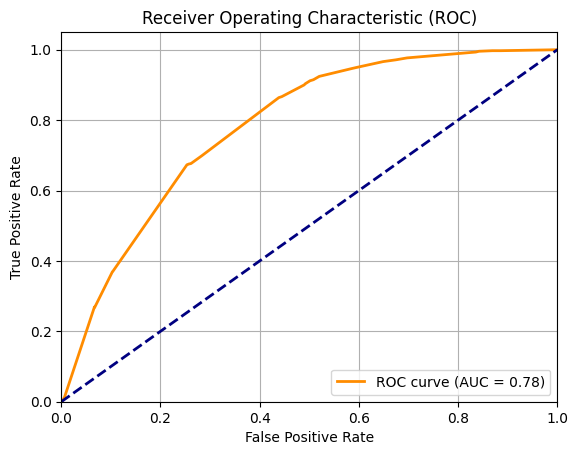

Tree depth 4
min_samples_leaf 6
goal                           0.307283
category_grouped_Web           0.184036
launch_to_state_change_days    0.156103
create_to_launch_days          0.120287
category_grouped_Software      0.110380
canceled                       0.034730
launch_to_deadline_days        0.027777
launched_at_yr                 0.016543
category_grouped_Hardware      0.010346
static_usd_rate                0.007930
created_at_hr                  0.007086
new                            0.003419
help                           0.003288
launched_at_hr                 0.003006
created_at_month               0.002803
deadline_day                   0.002383
launched_at_day                0.002051
created_at_weekday_Tuesday     0.000550
dtype: float64
Cross-validation scores: [0.49515504 0.59593023 0.74163839 0.49878817 0.68201648 0.74357731
 0.57876878 0.72418808 0.7338827  0.70770722]
Mean accuracy: 0.6502
Standard deviation of accuracy: 0.0943


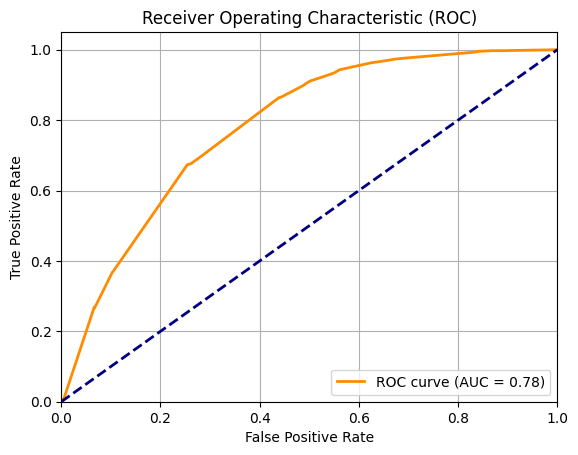

Tree depth 4
min_samples_leaf 7
goal                           0.305105
category_grouped_Web           0.184875
launch_to_state_change_days    0.156815
create_to_launch_days          0.123320
category_grouped_Software      0.110883
canceled                       0.034888
launch_to_deadline_days        0.024982
launched_at_yr                 0.016618
category_grouped_Hardware      0.010393
static_usd_rate                0.009025
created_at_hr                  0.005905
new                            0.003434
help                           0.003303
created_at_month               0.002816
launched_at_day                0.002654
deadline_day                   0.002394
launched_at_hr                 0.002037
created_at_weekday_Tuesday     0.000553
dtype: float64
Cross-validation scores: [0.49515504 0.59593023 0.74163839 0.49878817 0.68201648 0.74406205
 0.57779932 0.72418808 0.73339796 0.70722249]
Mean accuracy: 0.6500
Standard deviation of accuracy: 0.0943


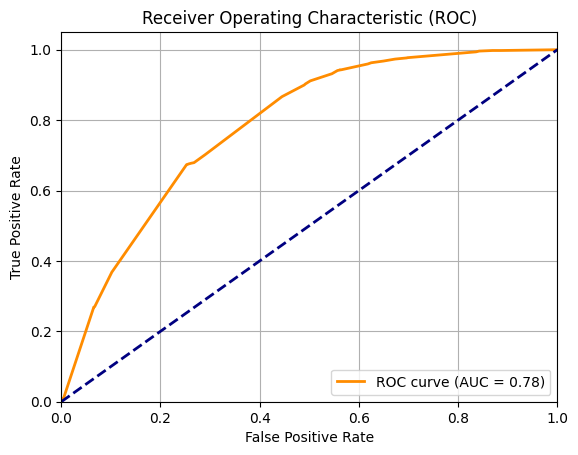

Tree depth 4
min_samples_leaf 8
goal                           0.305844
category_grouped_Web           0.185323
launch_to_state_change_days    0.157967
create_to_launch_days          0.124755
category_grouped_Software      0.108101
canceled                       0.034972
launch_to_deadline_days        0.025042
launched_at_yr                 0.016658
category_grouped_Hardware      0.010418
static_usd_rate                0.009047
created_at_month               0.005567
new                            0.003443
help                           0.003311
deadline_day                   0.002400
launched_at_day                0.002243
created_at_hr                  0.002151
launched_at_hr                 0.002042
created_at_weekday_Tuesday     0.000554
deadline_hr                    0.000164
dtype: float64
Cross-validation scores: [0.49515504 0.59447674 0.74163839 0.49878817 0.68201648 0.74551624
 0.57925351 0.72418808 0.73339796 0.70722249]
Mean accuracy: 0.6502
Standard deviation of accuracy: 0

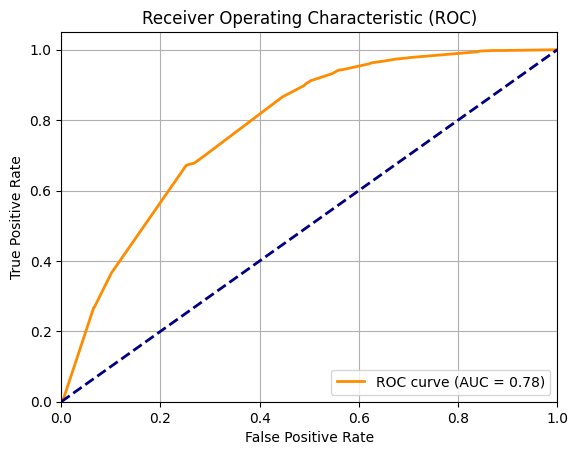

Tree depth 4
min_samples_leaf 9
goal                           0.306304
category_grouped_Web           0.185601
launch_to_state_change_days    0.157431
create_to_launch_days          0.128036
category_grouped_Software      0.108263
canceled                       0.035025
launch_to_deadline_days        0.025080
launched_at_yr                 0.016683
category_grouped_Hardware      0.010434
static_usd_rate                0.009061
created_at_month               0.005575
new                            0.003148
deadline_day                   0.002404
launched_at_day                0.002206
created_at_hr                  0.002154
launched_at_hr                 0.002045
created_at_weekday_Tuesday     0.000551
dtype: float64
Cross-validation scores: [0.49467054 0.60562016 0.74163839 0.49878817 0.68201648 0.74551624
 0.57925351 0.72418808 0.73339796 0.70722249]
Mean accuracy: 0.6512
Standard deviation of accuracy: 0.0939


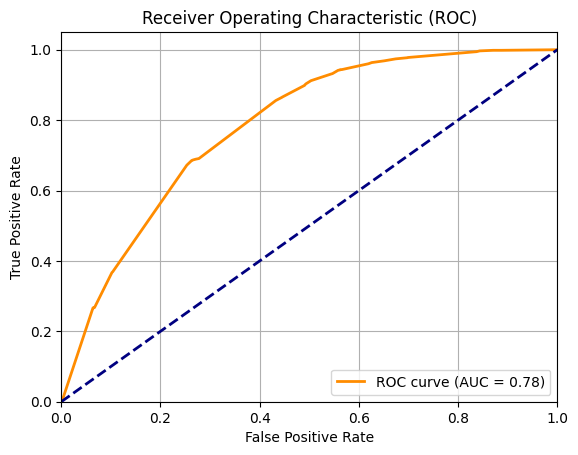

Tree depth 4
min_samples_leaf 10
goal                           0.306798
category_grouped_Web           0.185901
launch_to_state_change_days    0.157685
create_to_launch_days          0.127665
category_grouped_Software      0.108438
canceled                       0.035082
launch_to_deadline_days        0.025120
launched_at_yr                 0.016710
category_grouped_Hardware      0.010451
static_usd_rate                0.007337
created_at_month               0.005584
launched_at_day                0.003585
new                            0.003016
created_at_hr                  0.002158
launched_at_hr                 0.002048
deadline_hr                    0.001874
deadline_weekday_Saturday      0.000548
dtype: float64
Cross-validation scores: [0.49515504 0.60465116 0.74163839 0.49878817 0.68201648 0.74503151
 0.57925351 0.72418808 0.73339796 0.70722249]
Mean accuracy: 0.6511
Standard deviation of accuracy: 0.0938


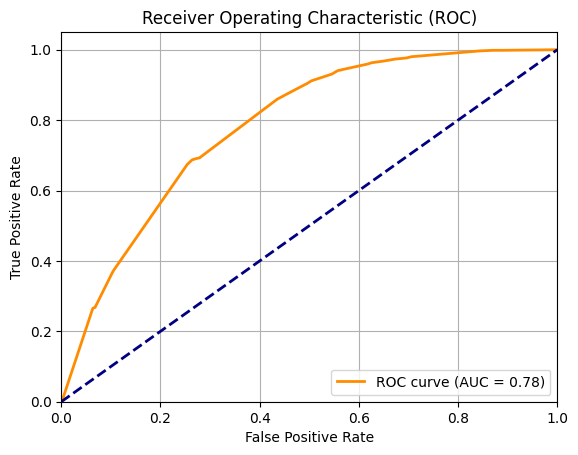

Tree depth 4
min_samples_leaf 11
goal                           0.306628
category_grouped_Web           0.185798
launch_to_state_change_days    0.159413
create_to_launch_days          0.127519
category_grouped_Software      0.108378
canceled                       0.035062
launch_to_deadline_days        0.025106
launched_at_yr                 0.016701
category_grouped_Hardware      0.010445
static_usd_rate                0.007333
created_at_month               0.005581
launched_at_day                0.003583
new                            0.002274
created_at_hr                  0.002157
launched_at_hr                 0.002047
deadline_hr                    0.001873
deadline_day                   0.000102
dtype: float64
Cross-validation scores: [0.49515504 0.60755814 0.74163839 0.49878817 0.68201648 0.74551624
 0.57925351 0.72418808 0.73339796 0.70722249]
Mean accuracy: 0.6515
Standard deviation of accuracy: 0.0938


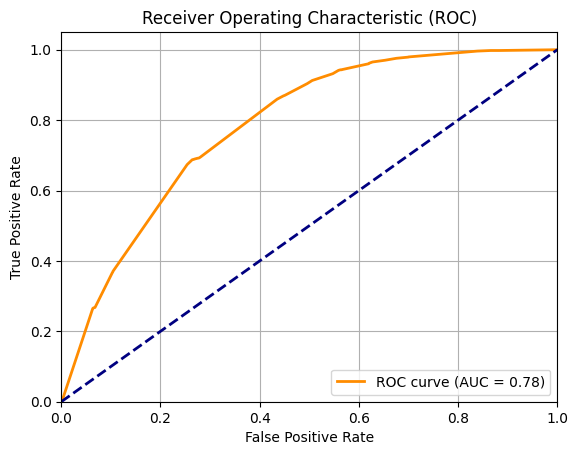

Tree depth 4
min_samples_leaf 12
goal                               0.308870
category_grouped_Web               0.185812
launch_to_state_change_days        0.159425
create_to_launch_days              0.127414
category_grouped_Software          0.108386
canceled                           0.035065
launch_to_deadline_days            0.025108
launched_at_yr                     0.016702
category_grouped_Hardware          0.010446
static_usd_rate                    0.007334
created_at_month                   0.005581
launched_at_day                    0.003583
created_at_hr                      0.002157
launched_at_hr                     0.002047
deadline_hr                        0.001873
state_changed_at_weekday_Sunday    0.000105
deadline_day                       0.000091
dtype: float64
Cross-validation scores: [0.49467054 0.60077519 0.74163839 0.49878817 0.68201648 0.74454678
 0.57973825 0.72418808 0.73339796 0.70722249]
Mean accuracy: 0.6507
Standard deviation of accuracy: 0.0940


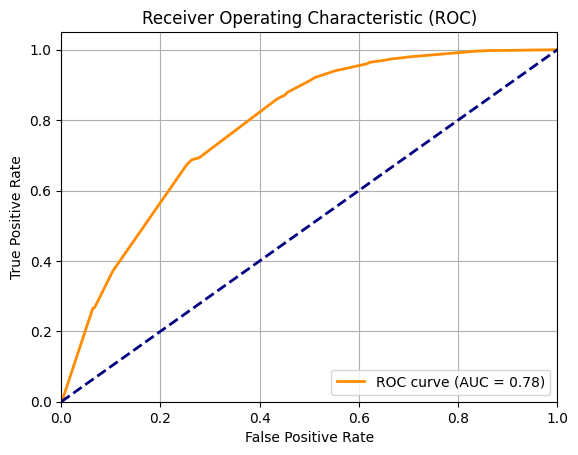

Tree depth 4
min_samples_leaf 13
goal                           0.309094
category_grouped_Web           0.185947
launch_to_state_change_days    0.158292
create_to_launch_days          0.126895
category_grouped_Software      0.108465
canceled                       0.035090
launch_to_deadline_days        0.026458
launched_at_yr                 0.016714
category_grouped_Hardware      0.010453
static_usd_rate                0.007339
created_at_month               0.005585
launched_at_day                0.003586
created_at_hr                  0.002158
launched_at_hr                 0.002048
deadline_hr                    0.001875
dtype: float64
Cross-validation scores: [0.49467054 0.5998062  0.74163839 0.49878817 0.68201648 0.74406205
 0.57973825 0.72418808 0.73339796 0.70722249]
Mean accuracy: 0.6506
Standard deviation of accuracy: 0.0940


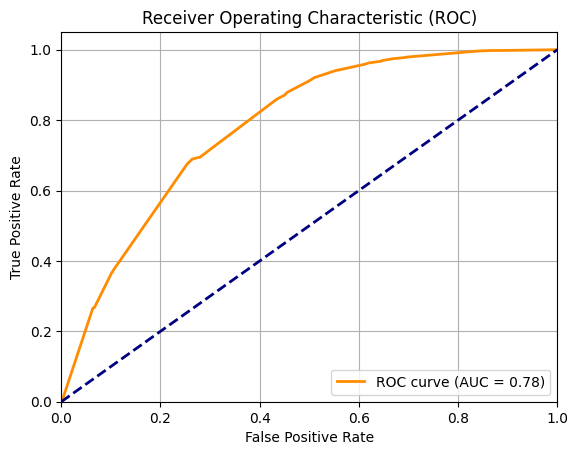

Tree depth 4
min_samples_leaf 14
goal                           0.309364
category_grouped_Web           0.185984
launch_to_state_change_days    0.158324
create_to_launch_days          0.126825
category_grouped_Software      0.108487
canceled                       0.035097
launch_to_deadline_days        0.024764
launched_at_yr                 0.016718
category_grouped_Hardware      0.010456
static_usd_rate                0.007340
created_at_month               0.004899
launched_at_day                0.003587
created_at_hr                  0.002159
launched_at_hr                 0.002049
deadline_hr                    0.001963
name_len_clean                 0.001894
blurb_len_clean                0.000092
dtype: float64
Cross-validation scores: [0.49467054 0.60125969 0.74163839 0.49878817 0.68153175 0.74454678
 0.57973825 0.72418808 0.73339796 0.70916142]
Mean accuracy: 0.6509
Standard deviation of accuracy: 0.0941


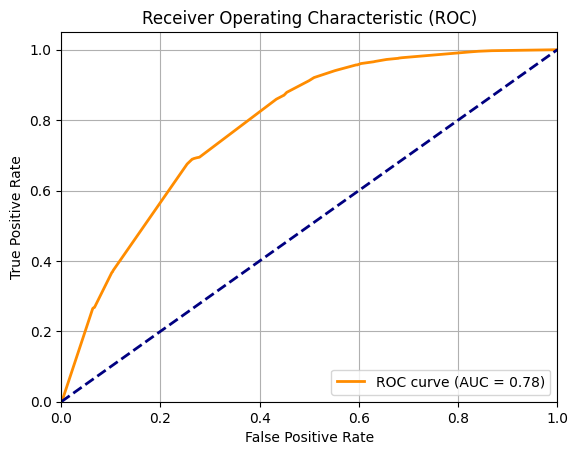

Tree depth 4
min_samples_leaf 2
goal                            0.277951
category_grouped_Web            0.165716
launch_to_state_change_days     0.141173
create_to_launch_days           0.117528
category_grouped_Software       0.102011
canceled                        0.067373
launch_to_deadline_days         0.039086
launched_at_yr                  0.014195
static_usd_rate                 0.011078
category_grouped_Hardware       0.009316
help                            0.007705
created_at_month                0.007692
new                             0.007082
category_grouped_Plays          0.006997
launched_at_hr                  0.005125
created_at_hr                   0.004595
launched_at_day                 0.004517
deadline_day                    0.004262
world                           0.001781
created_at_day                  0.001735
name_len_clean                  0.001446
deadline_month                  0.000967
created_at_weekday_Wednesday    0.000479
deadline_weekday_Tuesday 

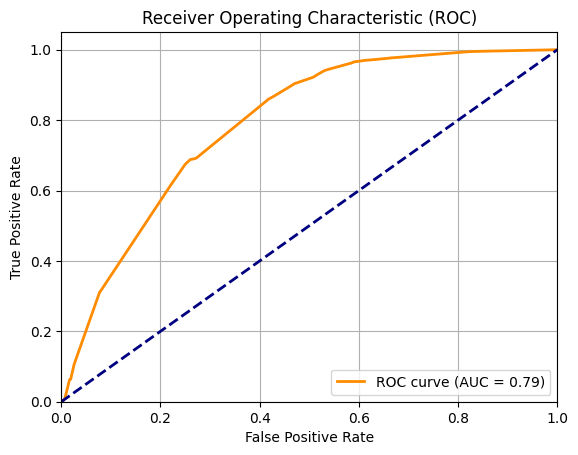

Tree depth 4
min_samples_leaf 3
goal                            0.282057
category_grouped_Web            0.165579
launch_to_state_change_days     0.144129
create_to_launch_days           0.115744
category_grouped_Software       0.101927
canceled                        0.067317
launch_to_deadline_days         0.035982
launched_at_yr                  0.014448
static_usd_rate                 0.009776
category_grouped_Hardware       0.009308
help                            0.007699
new                             0.007076
category_grouped_Plays          0.006991
created_at_month                0.005724
launched_at_day                 0.004513
launched_at_hr                  0.004329
deadline_day                    0.004258
created_at_hr                   0.003769
deadline_weekday_Saturday       0.003144
created_at_day                  0.001734
app                             0.001635
name_len_clean                  0.001445
created_at_weekday_Tuesday      0.000495
created_at_weekday_Wednes

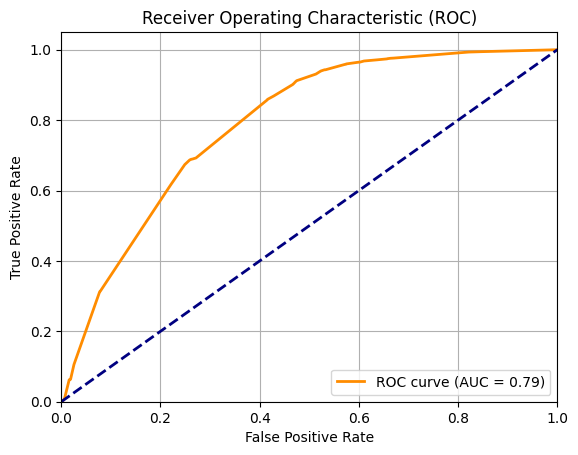

Tree depth 4
min_samples_leaf 4
goal                                 0.280890
category_grouped_Web                 0.166013
launch_to_state_change_days          0.144601
create_to_launch_days                0.114381
category_grouped_Software            0.102194
canceled                             0.067494
launch_to_deadline_days              0.035957
launched_at_yr                       0.014380
static_usd_rate                      0.009802
category_grouped_Hardware            0.009333
help                                 0.007719
new                                  0.007095
category_grouped_Plays               0.007009
created_at_month                     0.005739
created_at_hr                        0.004562
launched_at_hr                       0.003039
launched_at_day                      0.002952
deadline_weekday_Monday              0.002848
deadline_day                         0.002150
state_changed_at_weekday_Saturday    0.002042
created_at_day                       0.001738
ap

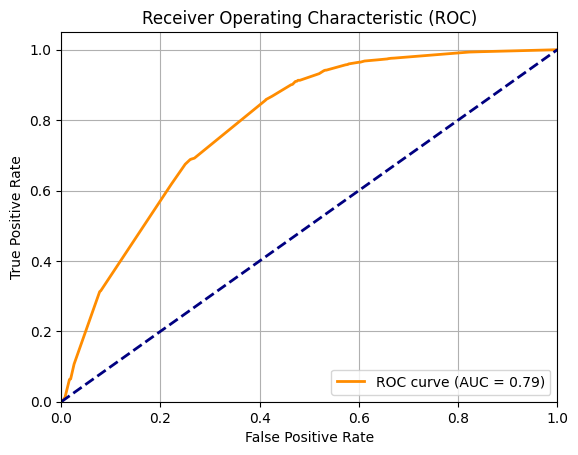

Tree depth 4
min_samples_leaf 5
goal                               0.280254
category_grouped_Web               0.166245
launch_to_state_change_days        0.143030
create_to_launch_days              0.117803
category_grouped_Software          0.105074
canceled                           0.067588
launch_to_deadline_days            0.036007
launched_at_yr                     0.016420
static_usd_rate                    0.009815
category_grouped_Hardware          0.009346
help                               0.007730
category_grouped_Plays             0.007019
created_at_month                   0.005618
created_at_hr                      0.004569
created_at_day                     0.003270
new                                0.003088
launched_at_hr                     0.003043
state_changed_at_weekday_Monday    0.002852
name_len_clean                     0.002562
deadline_day                       0.002153
launched_at_day                    0.001853
launched_at_weekday_Tuesday        0.001847


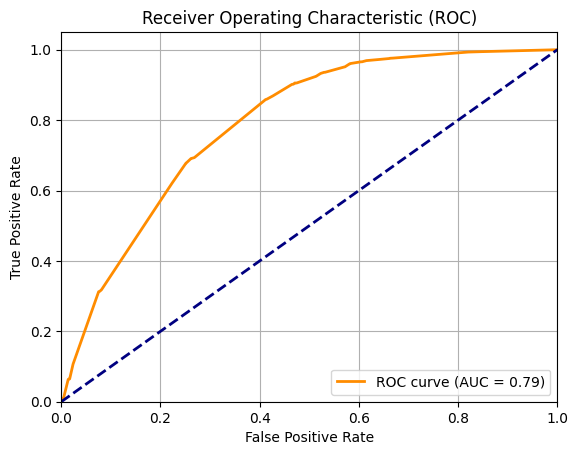

Tree depth 4
min_samples_leaf 6
goal                            0.282333
category_grouped_Web            0.166292
launch_to_state_change_days     0.141052
create_to_launch_days           0.116407
category_grouped_Software       0.105104
canceled                        0.067607
launch_to_deadline_days         0.036017
launched_at_yr                  0.014948
static_usd_rate                 0.009818
category_grouped_Hardware       0.009349
category_grouped_Plays          0.007021
help                            0.007004
created_at_hr                   0.006500
created_at_month                0.005620
new                             0.003089
launched_at_hr                  0.003044
deadline_weekday_Monday         0.002853
launched_at_day                 0.002808
name_len_clean                  0.002562
deadline_day                    0.002153
launched_at_month               0.001860
launched_at_weekday_Tuesday     0.001847
deadline_hr                     0.000936
created_at_day           

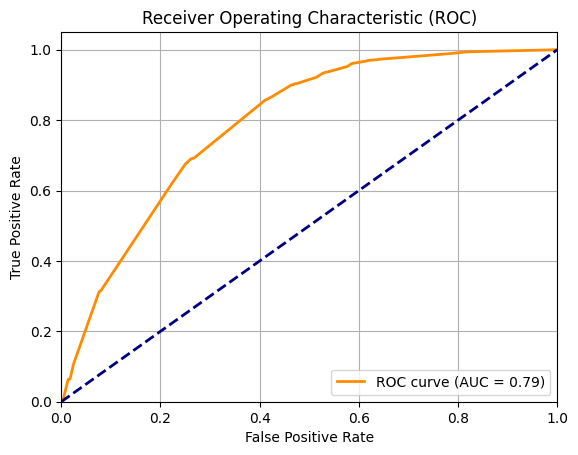

Tree depth 4
min_samples_leaf 7
goal                           0.280095
category_grouped_Web           0.167308
launch_to_state_change_days    0.143785
create_to_launch_days          0.120352
category_grouped_Software      0.105745
canceled                       0.068020
launch_to_deadline_days        0.033593
launched_at_yr                 0.015039
category_grouped_Hardware      0.009406
static_usd_rate                0.008168
category_grouped_Plays         0.007064
help                           0.007047
created_at_hr                  0.006152
created_at_month               0.005654
deadline_day                   0.003120
new                            0.003108
launched_at_hr                 0.003062
deadline_weekday_Monday        0.002870
launched_at_day                0.002812
launched_at_weekday_Tuesday    0.001859
deadline_hr                    0.001857
name_len_clean                 0.001460
DeadlineWeekend                0.000836
created_at_weekday_Saturday    0.000642
created_

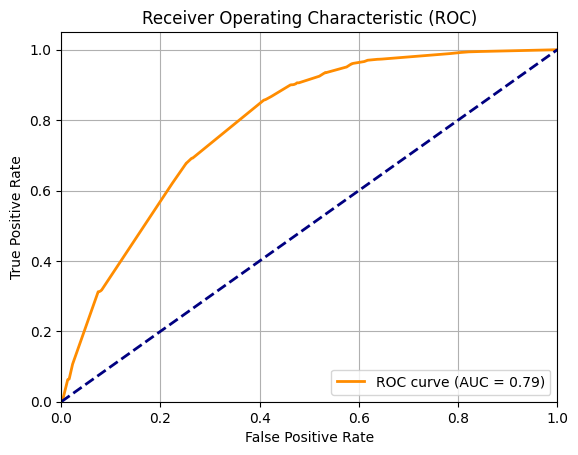

Tree depth 4
min_samples_leaf 8
goal                           0.280746
category_grouped_Web           0.168883
launch_to_state_change_days    0.143953
create_to_launch_days          0.124881
category_grouped_Software      0.103960
canceled                       0.068660
launch_to_deadline_days        0.034019
launched_at_yr                 0.015180
category_grouped_Hardware      0.009494
static_usd_rate                0.008244
category_grouped_Plays         0.007131
created_at_month               0.006366
help                           0.006324
launched_at_hr                 0.004255
new                            0.003137
launched_at_day                0.002959
created_at_hr                  0.002643
deadline_day                   0.002187
deadline_hr                    0.002024
launched_at_weekday_Tuesday    0.001876
name_len_clean                 0.001474
created_at_weekday_Saturday    0.000648
created_at_weekday_Tuesday     0.000505
created_at_weekday_Monday      0.000257
deadline

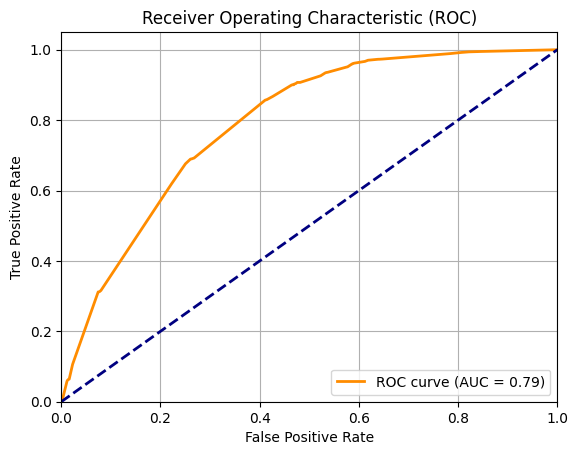

Tree depth 4
min_samples_leaf 9
goal                           0.280655
category_grouped_Web           0.169195
launch_to_state_change_days    0.143606
create_to_launch_days          0.125538
category_grouped_Software      0.104152
canceled                       0.068787
launch_to_deadline_days        0.033972
launched_at_yr                 0.015208
category_grouped_Hardware      0.009512
static_usd_rate                0.008260
category_grouped_Plays         0.007144
created_at_month               0.005082
launched_at_hr                 0.003385
launched_at_month              0.003239
launched_at_day                0.002965
new                            0.002870
help                           0.002707
created_at_hr                  0.002648
deadline_weekday_Monday        0.002260
deadline_day                   0.002191
deadline_hr                    0.001878
LaunchedTuesday                0.001668
name_len_clean                 0.001476
created_at_weekday_Saturday    0.000650
created_

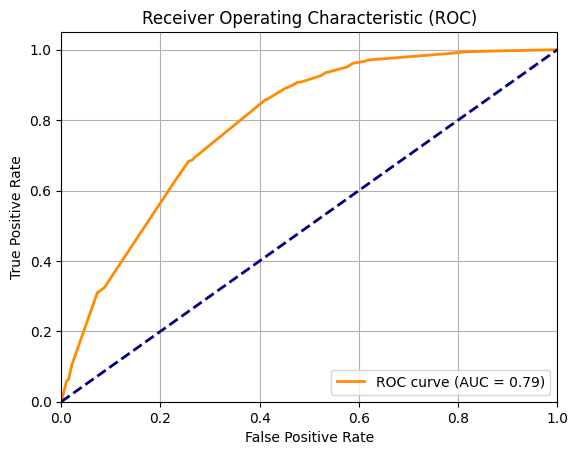

Tree depth 4
min_samples_leaf 10
goal                           0.281700
category_grouped_Web           0.170024
launch_to_state_change_days    0.144999
create_to_launch_days          0.121043
category_grouped_Software      0.104663
canceled                       0.069125
launch_to_deadline_days        0.034139
launched_at_yr                 0.015283
category_grouped_Hardware      0.010994
category_grouped_Plays         0.007179
static_usd_rate                0.006710
created_at_month               0.005107
launched_at_day                0.003696
deadline_hr                    0.003619
launched_at_hr                 0.003112
created_at_hr                  0.002922
new                            0.002759
launched_at_month              0.002604
deadline_weekday_Monday        0.002271
help                           0.002242
LaunchedTuesday                0.001677
name_len_clean                 0.001484
category_grouped_Other         0.000947
created_at_weekday_Saturday    0.000653
deadlin

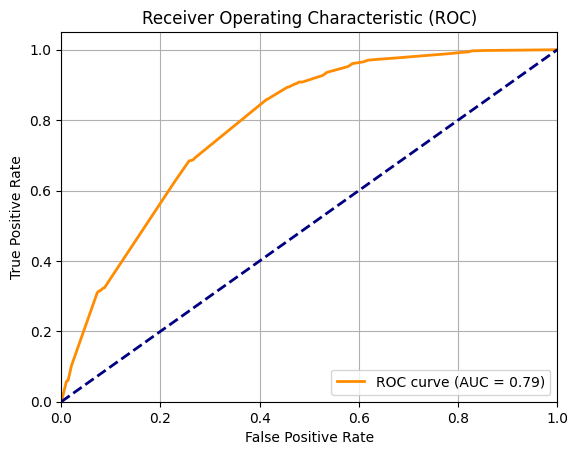

Tree depth 4
min_samples_leaf 11
goal                           0.281528
category_grouped_Web           0.169920
launch_to_state_change_days    0.144715
create_to_launch_days          0.121603
category_grouped_Software      0.104599
canceled                       0.069082
launch_to_deadline_days        0.035352
launched_at_yr                 0.015274
category_grouped_Hardware      0.010988
category_grouped_Plays         0.007174
static_usd_rate                0.006706
created_at_month               0.005104
launched_at_day                0.003694
deadline_hr                    0.003617
created_at_hr                  0.003513
launched_at_hr                 0.003110
launched_at_month              0.002602
deadline_weekday_Monday        0.002270
help                           0.002118
new                            0.002080
launched_at_weekday_Tuesday    0.001675
name_len_clean                 0.001483
category_grouped_Other         0.000946
created_at_weekday_Saturday    0.000652
deadlin

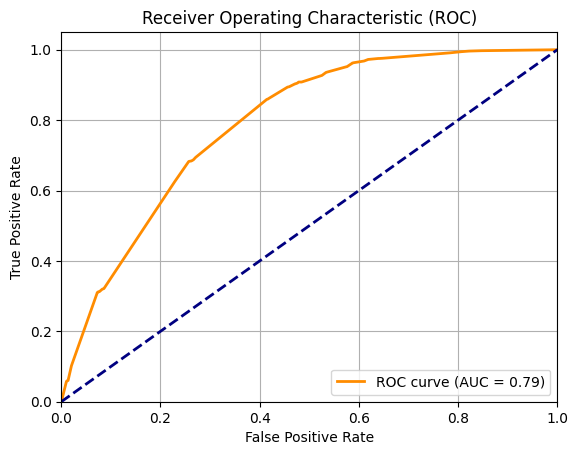

Tree depth 4
min_samples_leaf 12
goal                               0.283767
category_grouped_Web               0.170047
launch_to_state_change_days        0.145898
create_to_launch_days              0.121985
category_grouped_Software          0.104677
canceled                           0.069134
launch_to_deadline_days            0.034143
launched_at_yr                     0.015285
category_grouped_Hardware          0.010996
category_grouped_Plays             0.007180
static_usd_rate                    0.006711
created_at_month                   0.005108
launched_at_day                    0.003697
deadline_hr                        0.003619
launched_at_hr                     0.003113
created_at_hr                      0.002928
launched_at_month                  0.002604
deadline_weekday_Monday            0.002271
help                               0.002120
LaunchedTuesday                    0.001776
name_len_clean                     0.001484
created_at_weekday_Saturday        0.000653

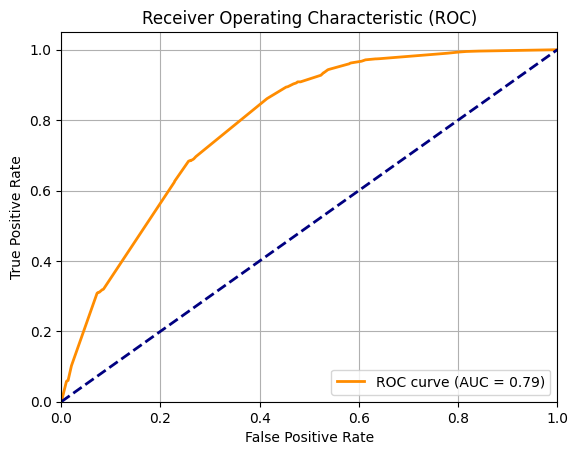

Tree depth 4
min_samples_leaf 13
goal                           0.284055
category_grouped_Web           0.170219
launch_to_state_change_days    0.144903
create_to_launch_days          0.121216
category_grouped_Software      0.104783
canceled                       0.069204
launch_to_deadline_days        0.035396
launched_at_yr                 0.015301
category_grouped_Hardware      0.011007
category_grouped_Plays         0.007187
static_usd_rate                0.006718
created_at_month               0.005113
launched_at_day                0.003700
deadline_hr                    0.003623
launched_at_hr                 0.003116
created_at_hr                  0.002831
launched_at_month              0.002607
deadline_weekday_Monday        0.002274
help                           0.002122
LaunchedTuesday                0.001778
name_len_clean                 0.001485
created_at_weekday_Saturday    0.000653
launched_at_weekday_Friday     0.000432
deadline_weekday_Tuesday       0.000195
blurb_l

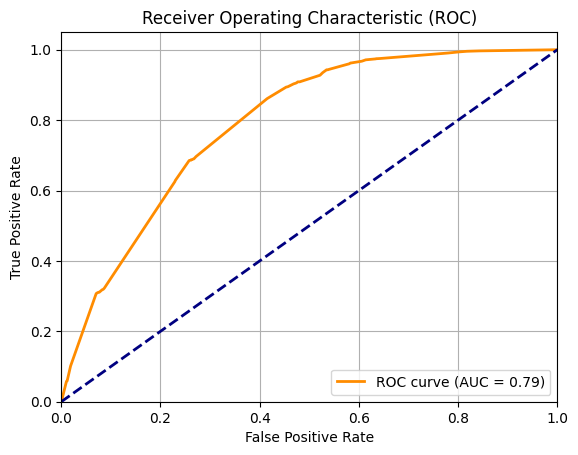

Tree depth 4
min_samples_leaf 14
goal                            0.284363
category_grouped_Web            0.170289
launch_to_state_change_days     0.144963
create_to_launch_days           0.121150
category_grouped_Software       0.104826
canceled                        0.069232
launch_to_deadline_days         0.035439
launched_at_yr                  0.015307
category_grouped_Hardware       0.011012
category_grouped_Plays          0.007190
static_usd_rate                 0.006721
created_at_month                0.004486
deadline_hr                     0.003624
launched_at_day                 0.003284
launched_at_hr                  0.003117
created_at_hr                   0.003000
launched_at_month               0.002608
deadline_weekday_Monday         0.002275
help                            0.002085
LaunchedTuesday                 0.001779
name_len_clean                  0.001734
created_at_weekday_Saturday     0.000654
currency_grouped_USD            0.000372
deadline_weekday_Tuesday

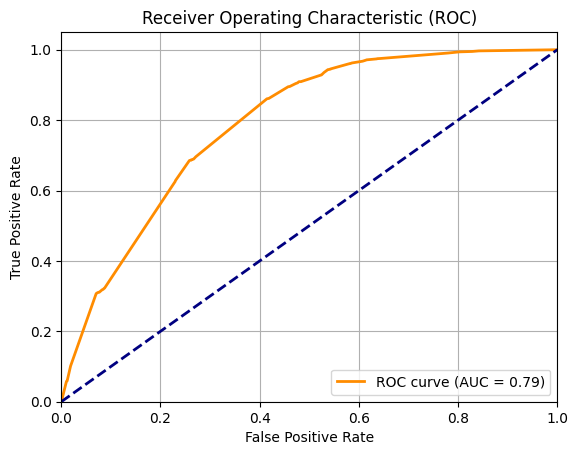

Tree depth 4
min_samples_leaf 2
goal                            0.261775
category_grouped_Web            0.152515
launch_to_state_change_days     0.134362
create_to_launch_days           0.113642
category_grouped_Software       0.093885
canceled                        0.062006
launch_to_deadline_days         0.044369
launched_at_hr                  0.026936
launched_at_yr                  0.014116
static_usd_rate                 0.010195
created_at_day                  0.009291
category_grouped_Hardware       0.008574
help                            0.007544
created_at_month                0.007079
launched_at_day                 0.006836
new                             0.006518
category_grouped_Plays          0.006439
launched_at_month               0.005377
deadline_day                    0.004960
created_at_hr                   0.004482
deadline_hr                     0.003300
world                           0.002871
deadline_weekday_Monday         0.002617
launched_at_weekday_Satur

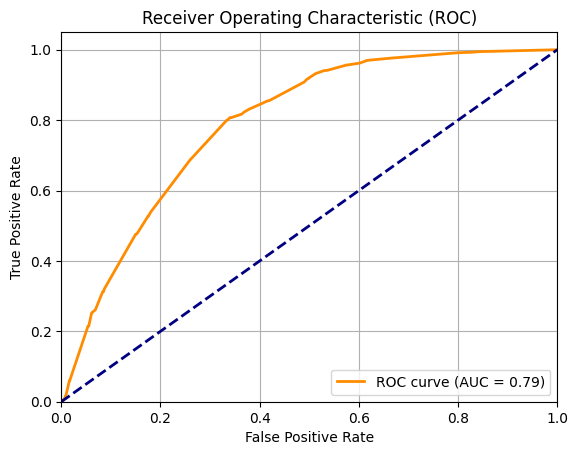

Tree depth 4
min_samples_leaf 3
goal                                 0.264512
category_grouped_Web                 0.152371
launch_to_state_change_days          0.131902
create_to_launch_days                0.112928
category_grouped_Software            0.093796
canceled                             0.061948
launch_to_deadline_days              0.047148
launched_at_hr                       0.026424
launched_at_yr                       0.014103
static_usd_rate                      0.011966
category_grouped_Hardware            0.008566
created_at_day                       0.008162
help                                 0.007085
new                                  0.006512
category_grouped_Plays               0.006433
launched_at_day                      0.006285
created_at_month                     0.005928
launched_at_month                    0.005372
deadline_day                         0.005198
created_at_hr                        0.004337
state_changed_at_weekday_Monday      0.002614
na

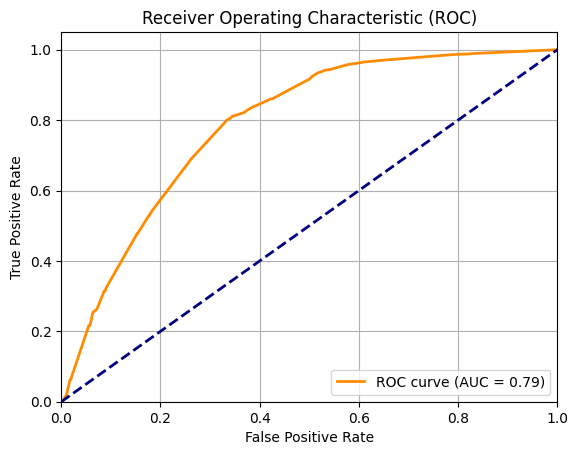

Tree depth 4
min_samples_leaf 4
goal                                 0.263904
category_grouped_Web                 0.153033
launch_to_state_change_days          0.136420
create_to_launch_days                0.114560
category_grouped_Software            0.094204
canceled                             0.062217
launch_to_deadline_days              0.043423
launched_at_hr                       0.025571
launched_at_yr                       0.013109
static_usd_rate                      0.012018
category_grouped_Hardware            0.008603
created_at_day                       0.008050
help                                 0.007116
new                                  0.006540
category_grouped_Plays               0.006461
launched_at_day                      0.005844
created_at_month                     0.005290
launched_at_month                    0.004971
created_at_hr                        0.004205
deadline_hr                          0.002835
deadline_weekday_Monday              0.002625
na

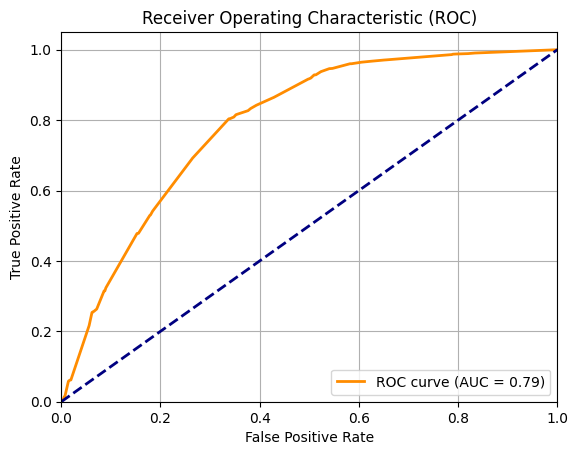

Tree depth 4
min_samples_leaf 5
goal                               0.267978
category_grouped_Web               0.153898
launch_to_state_change_days        0.132311
create_to_launch_days              0.112080
category_grouped_Software          0.097270
canceled                           0.062568
launch_to_deadline_days            0.046612
launched_at_hr                     0.025620
launched_at_yr                     0.015200
static_usd_rate                    0.011143
category_grouped_Hardware          0.008652
created_at_day                     0.008502
help                               0.007156
category_grouped_Plays             0.006498
launched_at_month                  0.006372
created_at_month                   0.006323
created_at_hr                      0.005885
new                                0.004727
launched_at_day                    0.002939
state_changed_at_weekday_Monday    0.002640
name_len_clean                     0.002371
deadline_day                       0.001993


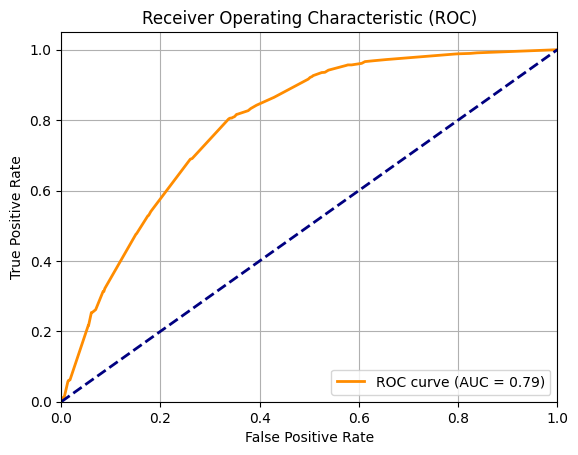

Tree depth 4
min_samples_leaf 6
goal                               0.270255
category_grouped_Web               0.154965
launch_to_state_change_days        0.132073
create_to_launch_days              0.112660
category_grouped_Software          0.097945
canceled                           0.063002
launch_to_deadline_days            0.046670
launched_at_hr                     0.028069
launched_at_yr                     0.013929
static_usd_rate                    0.009149
category_grouped_Hardware          0.008712
created_at_month                   0.007094
created_at_hr                      0.006599
category_grouped_Plays             0.006543
help                               0.006527
created_at_day                     0.006062
launched_at_day                    0.004245
launched_at_month                  0.004210
new                                0.002879
deadline_weekday_Monday            0.002659
deadline_day                       0.002402
launched_at_weekday_Saturday       0.001764


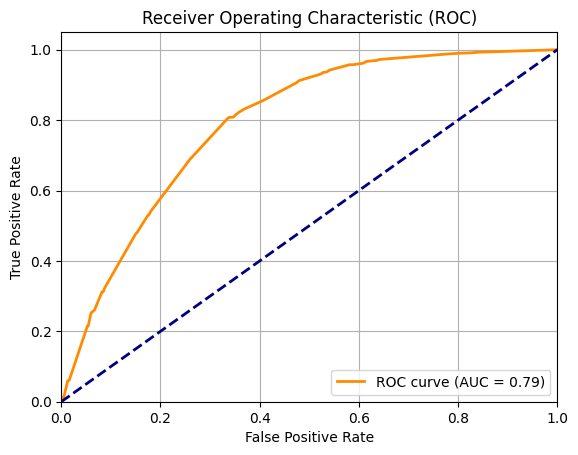

Tree depth 4
min_samples_leaf 7
goal                               0.269698
category_grouped_Web               0.155675
launch_to_state_change_days        0.133788
create_to_launch_days              0.114035
category_grouped_Software          0.098393
canceled                           0.063291
launch_to_deadline_days            0.045717
launched_at_hr                     0.027701
launched_at_yr                     0.016231
category_grouped_Hardware          0.008752
static_usd_rate                    0.007600
category_grouped_Plays             0.006573
help                               0.006557
created_at_hr                      0.005724
created_at_month                   0.005357
created_at_day                     0.005111
launched_at_month                  0.004229
launched_at_day                    0.003647
deadline_day                       0.003286
new                                0.002892
state_changed_at_weekday_Monday    0.002671
launched_at_weekday_Saturday       0.001772


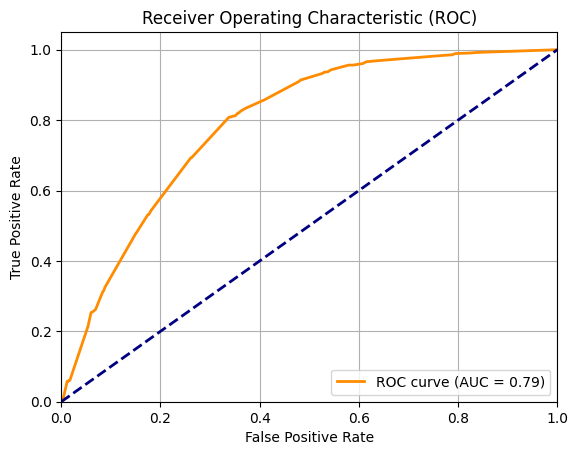

Tree depth 4
min_samples_leaf 8
goal                            0.270547
category_grouped_Web            0.157381
launch_to_state_change_days     0.134578
create_to_launch_days           0.118294
category_grouped_Software       0.096880
canceled                        0.063984
launch_to_deadline_days         0.046024
launched_at_hr                  0.028002
launched_at_yr                  0.018192
category_grouped_Hardware       0.008848
static_usd_rate                 0.007683
category_grouped_Plays          0.006645
created_at_month                0.006035
help                            0.005893
created_at_day                  0.005124
launched_at_day                 0.004525
launched_at_month               0.004275
new                             0.002924
created_at_hr                   0.002463
deadline_day                    0.002339
LaunchedTuesday                 0.001748
deadline_hr                     0.001747
name_len_clean                  0.001373
world                    

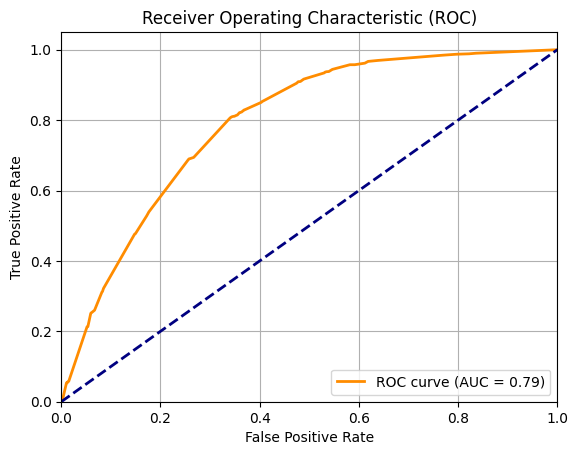

Tree depth 4
min_samples_leaf 9
goal                            0.270202
category_grouped_Web            0.157996
launch_to_state_change_days     0.136211
create_to_launch_days           0.121892
category_grouped_Software       0.097259
canceled                        0.064235
launch_to_deadline_days         0.045171
launched_at_hr                  0.026036
launched_at_yr                  0.016473
category_grouped_Hardware       0.008882
static_usd_rate                 0.007713
category_grouped_Plays          0.006671
created_at_month                0.005802
launched_at_month               0.004112
launched_at_day                 0.003780
created_at_day                  0.003632
new                             0.002680
help                            0.002528
created_at_hr                   0.002473
launched_at_weekday_Tuesday     0.002249
deadline_day                    0.002244
deadline_weekday_Monday         0.002110
deadline_hr                     0.001842
LaunchedTuesday          

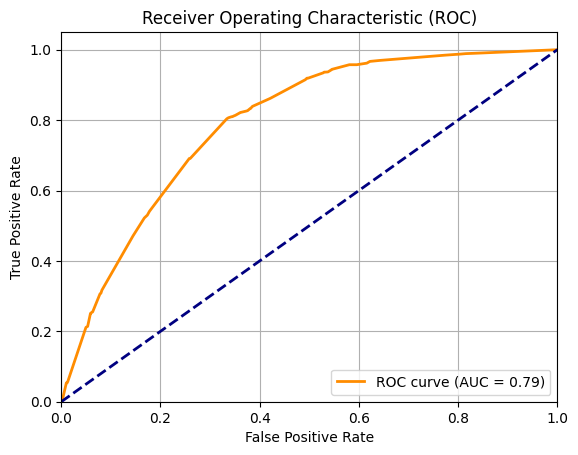

Tree depth 4
min_samples_leaf 10
goal                                 0.272236
category_grouped_Web                 0.159184
launch_to_state_change_days          0.136831
create_to_launch_days                0.118450
category_grouped_Software            0.097990
canceled                             0.064718
launch_to_deadline_days              0.046988
launched_at_hr                       0.026231
launched_at_yr                       0.014309
category_grouped_Hardware            0.010294
category_grouped_Plays               0.006721
static_usd_rate                      0.006283
created_at_month                     0.005511
launched_at_day                      0.004479
deadline_hr                          0.004475
launched_at_weekday_Tuesday          0.003836
created_at_day                       0.003659
created_at_hr                        0.002735
new                                  0.002583
launched_at_month                    0.002438
deadline_weekday_Monday              0.002126
h

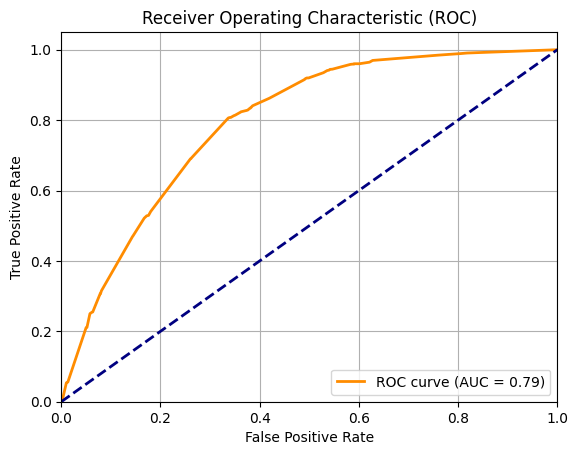

Tree depth 4
min_samples_leaf 11
goal                            0.271927
category_grouped_Web            0.159186
launch_to_state_change_days     0.139114
create_to_launch_days           0.116724
category_grouped_Software       0.097991
canceled                        0.064718
launch_to_deadline_days         0.047732
launched_at_hr                  0.026296
launched_at_yr                  0.014309
category_grouped_Hardware       0.010294
category_grouped_Plays          0.006721
static_usd_rate                 0.006283
created_at_month                0.005511
launched_at_day                 0.004541
deadline_hr                     0.004290
created_at_day                  0.003659
created_at_hr                   0.003291
launched_at_month               0.002438
launched_at_weekday_Tuesday     0.002266
deadline_weekday_Monday         0.002126
help                            0.001985
new                             0.001949
LaunchedTuesday                 0.001570
app                     

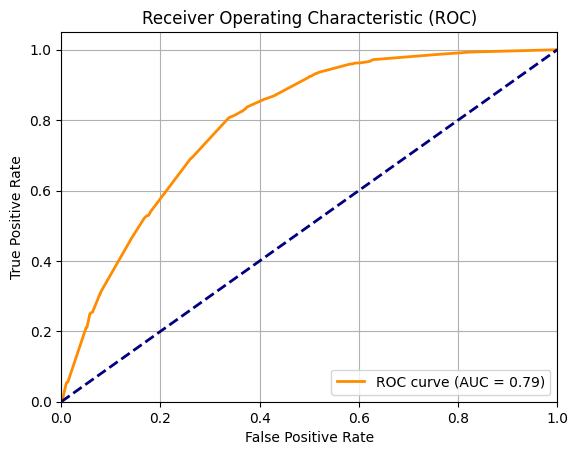

Tree depth 4
min_samples_leaf 12
goal                               0.273054
category_grouped_Web               0.160428
launch_to_state_change_days        0.144571
create_to_launch_days              0.116409
category_grouped_Software          0.098093
canceled                           0.064785
launch_to_deadline_days            0.041978
launched_at_hr                     0.026259
launched_at_yr                     0.014324
category_grouped_Hardware          0.010304
category_grouped_Plays             0.006728
static_usd_rate                    0.006289
created_at_month                   0.005516
deadline_hr                        0.005261
launched_at_day                    0.003987
launched_at_weekday_Tuesday        0.003933
created_at_day                     0.003663
created_at_hr                      0.002743
launched_at_month                  0.002440
deadline_weekday_Monday            0.002129
help                               0.001987
app                                0.001557

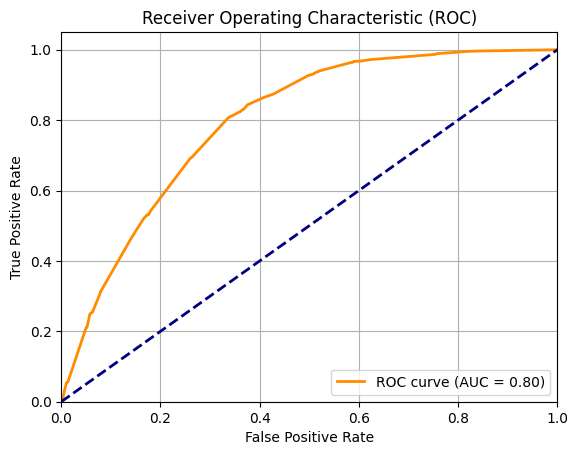

Tree depth 4
min_samples_leaf 13
goal                            0.273663
category_grouped_Web            0.160786
launch_to_state_change_days     0.144810
create_to_launch_days           0.117806
category_grouped_Software       0.098312
canceled                        0.064930
launch_to_deadline_days         0.041226
launched_at_hr                  0.026317
launched_at_yr                  0.014426
category_grouped_Hardware       0.010327
category_grouped_Plays          0.006743
static_usd_rate                 0.006303
created_at_month                0.005529
deadline_hr                     0.005271
launched_at_day                 0.004468
created_at_day                  0.003671
created_at_hr                   0.002703
launched_at_month               0.002446
deadline_weekday_Monday         0.002133
help                            0.001991
LaunchedTuesday                 0.001668
app                             0.001560
name_len_clean                  0.001394
created_at_weekday_Satur

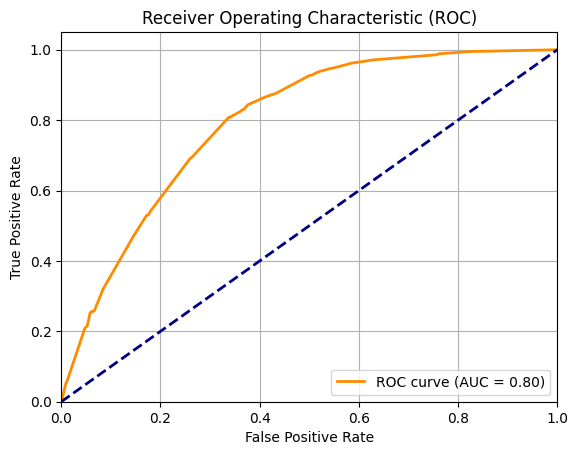

Tree depth 4
min_samples_leaf 14
goal                                  0.273505
category_grouped_Web                  0.160588
launch_to_state_change_days           0.143136
create_to_launch_days                 0.117331
category_grouped_Software             0.098191
canceled                              0.064850
launch_to_deadline_days               0.042310
launched_at_hr                        0.026721
launched_at_yr                        0.015056
category_grouped_Hardware             0.010315
category_grouped_Plays                0.006735
static_usd_rate                       0.006296
launched_at_day                       0.006069
deadline_hr                           0.005544
created_at_month                      0.004202
created_at_hr                         0.002810
created_at_day                        0.002585
launched_at_month                     0.002443
deadline_weekday_Monday               0.002131
help                                  0.001953
LaunchedTuesday            

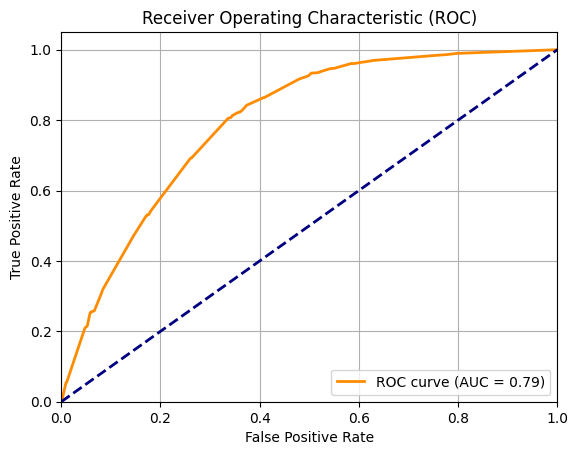

Tree depth 4
min_samples_leaf 2
goal                                  0.247905
category_grouped_Web                  0.138258
launch_to_state_change_days           0.127726
create_to_launch_days                 0.109131
category_grouped_Software             0.085109
canceled                              0.056210
launch_to_deadline_days               0.041380
launched_at_yr                        0.025270
launched_at_hr                        0.024418
deadline_hr                           0.015195
created_at_day                        0.014248
new                                   0.011428
static_usd_rate                       0.009595
category_grouped_Hardware             0.007773
created_at_month                      0.007621
LaunchedTuesday                       0.007127
blurb_len_clean                       0.007018
help                                  0.006839
launched_at_day                       0.006324
category_grouped_Plays                0.005838
deadline_day                

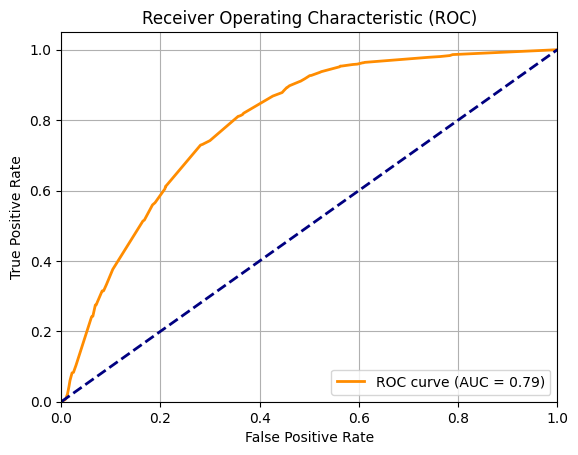

Tree depth 4
min_samples_leaf 3
goal                               0.252610
category_grouped_Web               0.138662
launch_to_state_change_days        0.123250
create_to_launch_days              0.107568
category_grouped_Software          0.085357
canceled                           0.056374
launch_to_deadline_days            0.046335
launched_at_yr                     0.025344
launched_at_hr                     0.025220
deadline_hr                        0.015006
launched_at_day                    0.010234
new                                0.010093
category_grouped_Hardware          0.008946
created_at_day                     0.008340
static_usd_rate                    0.008187
created_at_month                   0.007181
LaunchedTuesday                    0.007148
blurb_len_clean                    0.006460
help                               0.006447
category_grouped_Plays             0.005855
deadline_day                       0.005495
launched_at_month                  0.005287


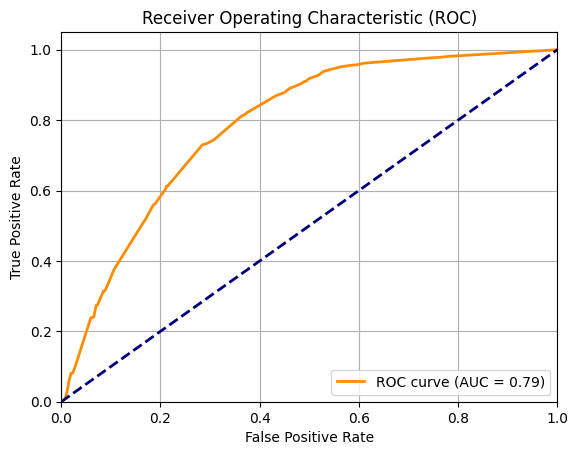

Tree depth 4
min_samples_leaf 4
goal                                  0.254858
category_grouped_Web                  0.139926
launch_to_state_change_days           0.125148
create_to_launch_days                 0.107704
category_grouped_Software             0.086135
canceled                              0.056888
launch_to_deadline_days               0.045685
launched_at_hr                        0.025605
launched_at_yr                        0.024610
deadline_hr                           0.013021
static_usd_rate                       0.010988
category_grouped_Hardware             0.009938
new                                   0.009398
launched_at_weekday_Tuesday           0.009288
help                                  0.007232
created_at_day                        0.007132
launched_at_day                       0.006582
launched_at_month                     0.006272
name_len_clean                        0.006110
category_grouped_Plays                0.005908
blurb_len_clean             

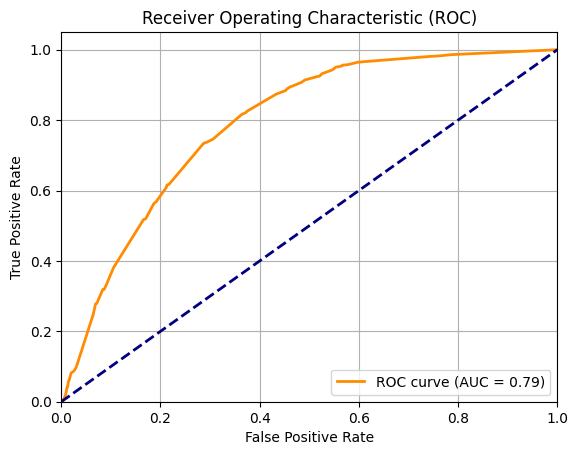

Tree depth 4
min_samples_leaf 5
goal                                  0.257566
category_grouped_Web                  0.141353
launch_to_state_change_days           0.125048
create_to_launch_days                 0.109298
category_grouped_Software             0.089341
canceled                              0.057468
launch_to_deadline_days               0.044102
launched_at_hr                        0.025482
launched_at_yr                        0.025271
deadline_hr                           0.013418
launched_at_weekday_Tuesday           0.010953
created_at_day                        0.009953
static_usd_rate                       0.008346
category_grouped_Hardware             0.007946
created_at_month                      0.007417
help                                  0.006573
category_grouped_Plays                0.005968
blurb_len_clean                       0.005761
created_at_hr                         0.005515
launched_at_month                     0.005421
name_len_clean              

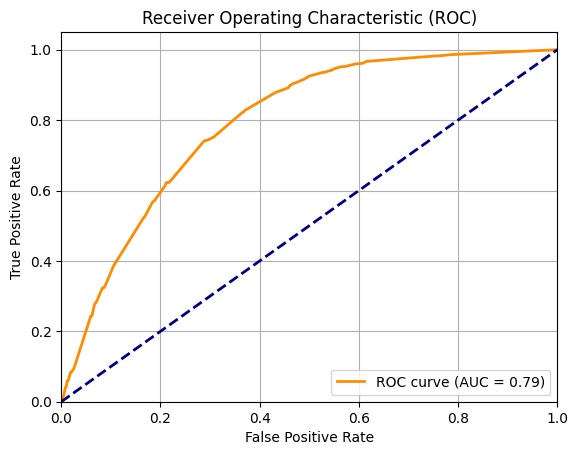

Tree depth 4
min_samples_leaf 6
goal                                  0.260067
category_grouped_Web                  0.142986
launch_to_state_change_days           0.129222
create_to_launch_days                 0.107045
category_grouped_Software             0.090373
canceled                              0.058132
launch_to_deadline_days               0.039930
launched_at_hr                        0.027652
launched_at_yr                        0.024293
deadline_hr                           0.014185
launched_at_weekday_Tuesday           0.008959
category_grouped_Hardware             0.008837
static_usd_rate                       0.008442
launched_at_month                     0.007411
created_at_hr                         0.006660
created_at_day                        0.006477
created_at_month                      0.006431
help                                  0.006164
category_grouped_Plays                0.006037
blurb_len_clean                       0.005828
name_len_clean              

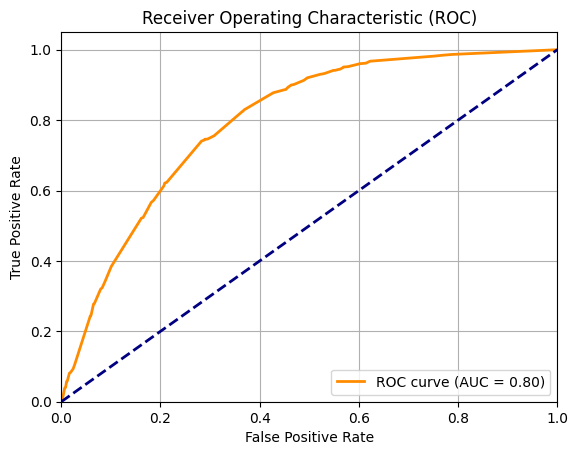

Tree depth 4
min_samples_leaf 7
goal                                  0.260129
category_grouped_Web                  0.143677
launch_to_state_change_days           0.126369
create_to_launch_days                 0.109878
category_grouped_Software             0.090810
canceled                              0.058413
launch_to_deadline_days               0.042971
launched_at_hr                        0.026032
launched_at_yr                        0.025156
deadline_hr                           0.013808
launched_at_month                     0.009084
LaunchedTuesday                       0.009002
category_grouped_Hardware             0.008879
static_usd_rate                       0.007014
category_grouped_Plays                0.006066
help                                  0.006051
created_at_day                        0.005911
blurb_len_clean                       0.005856
created_at_hr                         0.005629
name_len_clean                        0.005314
created_at_month            

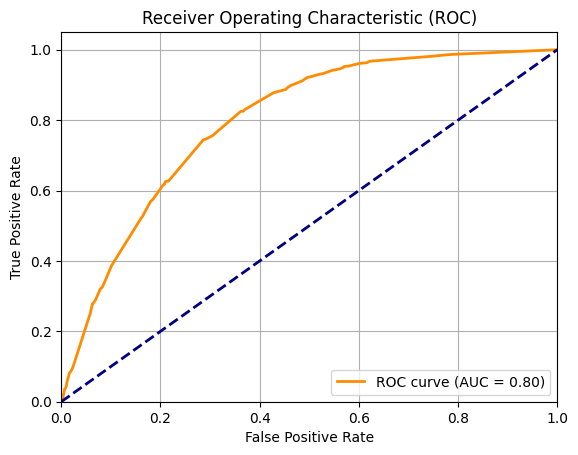

Tree depth 4
min_samples_leaf 8
goal                            0.259554
category_grouped_Web            0.145542
launch_to_state_change_days     0.128325
create_to_launch_days           0.113745
category_grouped_Software       0.089592
canceled                        0.059171
launch_to_deadline_days         0.043235
launched_at_hr                  0.025895
launched_at_yr                  0.025797
deadline_hr                     0.014116
LaunchedTuesday                 0.009119
category_grouped_Hardware       0.008182
launched_at_month               0.007864
static_usd_rate                 0.007732
category_grouped_Plays          0.006145
created_at_day                  0.006099
blurb_len_clean                 0.005932
created_at_month                0.005584
help                            0.005450
name_len_clean                  0.005383
launched_at_day                 0.004697
created_at_hr                   0.003220
category_grouped_Musical        0.002713
new                      

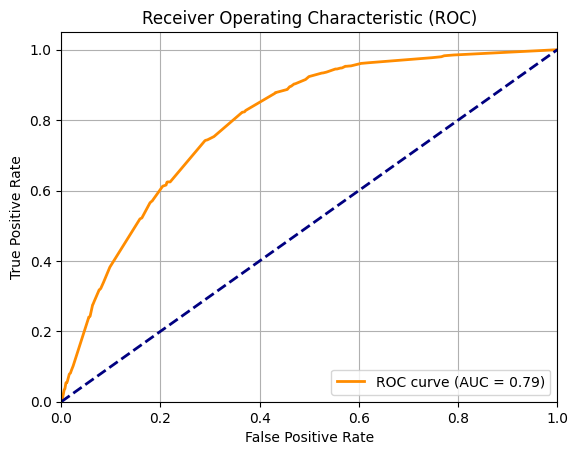

Tree depth 4
min_samples_leaf 9
goal                            0.260923
category_grouped_Web            0.146066
launch_to_state_change_days     0.128286
create_to_launch_days           0.118524
category_grouped_Software       0.089915
canceled                        0.059384
launch_to_deadline_days         0.042915
launched_at_hr                  0.025579
launched_at_yr                  0.023681
deadline_hr                     0.014395
launched_at_month               0.008392
category_grouped_Hardware       0.008211
LaunchedTuesday                 0.007529
static_usd_rate                 0.007131
category_grouped_Plays          0.006167
blurb_len_clean                 0.005953
created_at_day                  0.005707
name_len_clean                  0.005402
created_at_hr                   0.004902
launched_at_day                 0.004458
created_at_month                0.004387
launched_at_weekday_Tuesday     0.003520
category_grouped_Musical        0.002723
new                      

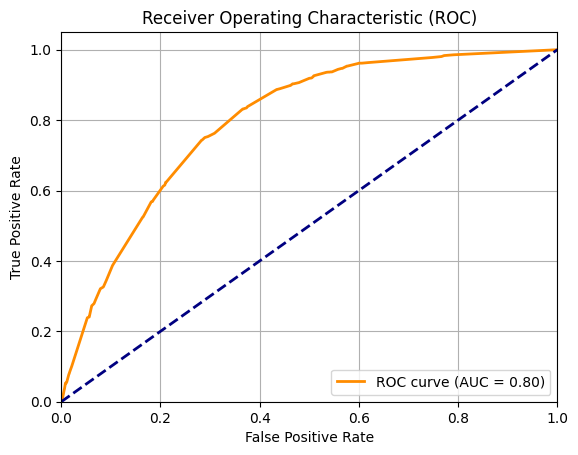

Tree depth 4
min_samples_leaf 10
goal                                  0.264588
category_grouped_Web                  0.147493
launch_to_state_change_days           0.134820
create_to_launch_days                 0.115527
category_grouped_Software             0.090793
canceled                              0.059964
launch_to_deadline_days               0.038858
launched_at_hr                        0.025420
launched_at_yr                        0.021792
deadline_hr                           0.016739
LaunchedTuesday                       0.011157
category_grouped_Hardware             0.009538
category_grouped_Plays                0.006227
blurb_len_clean                       0.006101
launched_at_month                     0.006064
static_usd_rate                       0.005821
name_len_clean                        0.005455
created_at_hr                         0.005135
created_at_month                      0.005106
created_at_day                        0.004955
launched_at_day            

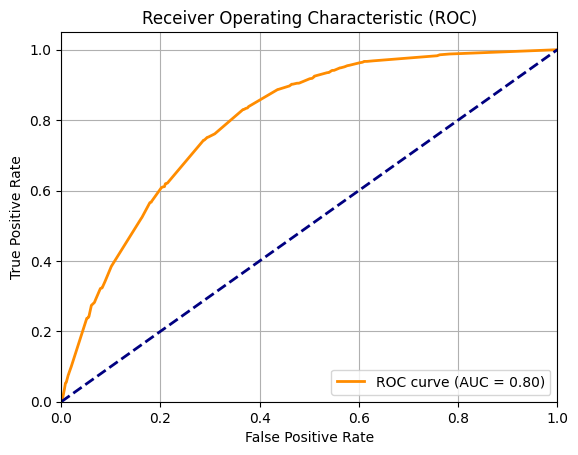

Tree depth 4
min_samples_leaf 11
goal                            0.263996
category_grouped_Web            0.147728
launch_to_state_change_days     0.136664
create_to_launch_days           0.115980
category_grouped_Software       0.090938
canceled                        0.060060
launch_to_deadline_days         0.039602
launched_at_hr                  0.026183
launched_at_yr                  0.021826
deadline_hr                     0.016324
category_grouped_Hardware       0.009553
launched_at_weekday_Tuesday     0.009072
category_grouped_Plays          0.006237
blurb_len_clean                 0.006110
static_usd_rate                 0.005831
name_len_clean                  0.005463
launched_at_month               0.005376
created_at_month                0.005172
created_at_day                  0.004963
launched_at_day                 0.004644
created_at_hr                   0.003787
category_grouped_Musical        0.002754
LaunchedTuesday                 0.002103
deadline_weekday_Monday 

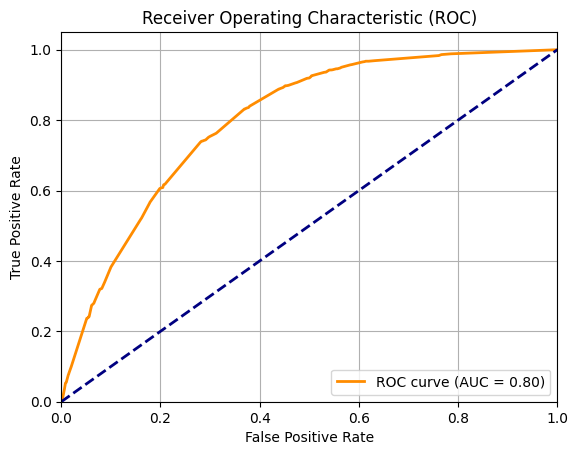

Tree depth 4
min_samples_leaf 12
goal                                  0.262518
category_grouped_Web                  0.149806
launch_to_state_change_days           0.137925
create_to_launch_days                 0.115582
category_grouped_Software             0.091598
canceled                              0.060496
launch_to_deadline_days               0.039625
launched_at_hr                        0.024520
launched_at_yr                        0.021985
deadline_hr                           0.017345
category_grouped_Hardware             0.009622
launched_at_weekday_Tuesday           0.009224
created_at_month                      0.006845
category_grouped_Plays                0.006283
blurb_len_clean                       0.006065
static_usd_rate                       0.005942
name_len_clean                        0.005503
created_at_day                        0.004657
created_at_hr                         0.004301
launched_at_day                       0.003969
launched_at_month          

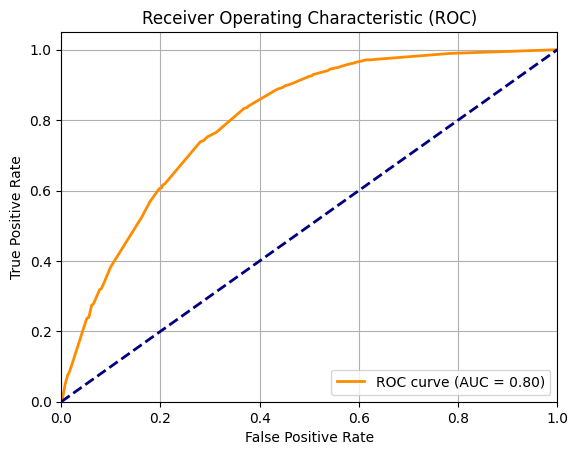

Tree depth 4
min_samples_leaf 13
goal                            0.262854
category_grouped_Web            0.150433
launch_to_state_change_days     0.138240
create_to_launch_days           0.113015
category_grouped_Software       0.091982
canceled                        0.060749
launch_to_deadline_days         0.041120
launched_at_hr                  0.025236
launched_at_yr                  0.023011
deadline_hr                     0.016344
category_grouped_Hardware       0.009662
LaunchedTuesday                 0.007702
created_at_month                0.006874
category_grouped_Plays          0.006309
blurb_len_clean                 0.006164
static_usd_rate                 0.005897
name_len_clean                  0.005526
created_at_day                  0.005087
launched_at_month               0.004141
launched_at_day                 0.004109
created_at_hr                   0.004070
category_grouped_Musical        0.002785
deadline_weekday_Monday         0.001996
help                    

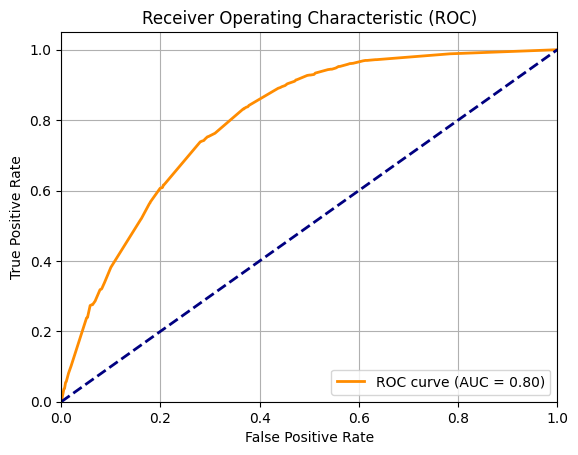

Tree depth 4
min_samples_leaf 14
goal                            0.262986
category_grouped_Web            0.150441
launch_to_state_change_days     0.137879
create_to_launch_days           0.112576
category_grouped_Software       0.091987
canceled                        0.060753
launch_to_deadline_days         0.040189
launched_at_hr                  0.024624
launched_at_yr                  0.023788
deadline_hr                     0.016739
category_grouped_Hardware       0.009663
LaunchedTuesday                 0.007703
category_grouped_Plays          0.006309
created_at_month                0.006169
blurb_len_clean                 0.006165
static_usd_rate                 0.005898
launched_at_day                 0.005809
name_len_clean                  0.005744
created_at_hr                   0.004535
created_at_day                  0.004309
launched_at_month               0.003529
category_grouped_Musical        0.002785
deadline_weekday_Monday         0.001996
help                    

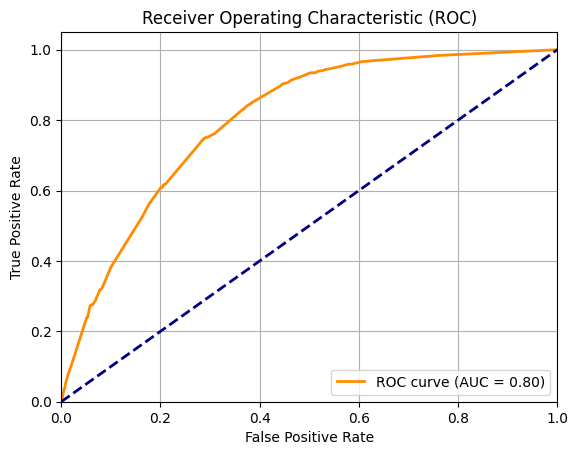

In [ ]:
model_score_stats = []

for depth in range(2, 10):
    for min_samples_leaf in range(2, 15):
        print(f"Tree depth {i}")
        print(f"min_samples_leaf {min_samples_leaf}")

        clf = DecisionTreeClassifier(max_depth=depth, random_state=42, criterion='gini', min_samples_leaf=min_samples_leaf)
        clf.fit(X_train, y_train)

        cv_scores = cross_val_score(clf, X, y, cv=10)

        #examine the feature importance
        importances = clf.feature_importances_
        feature_ranks = pd.Series(importances, index=X.columns).sort_values(ascending=False)
        filtered_ranks = feature_ranks[feature_ranks > 0]
        print(filtered_ranks)
        #for index, value in zip(feature_ranks.index, feature_ranks.values):
        #    print(index, value)
        #print(feature_ranks)
        #split_feature_index = clf.tree_.feature[0]
        #print("Split on feature:", X.columns[split_feature_index])

        model_score_stats.append({"model": clf, "depth": i, "min_samples_leaf":min_samples_leaf, "mean_score": cv_scores.mean(), "score_std":cv_scores.std()})

        print(f"Cross-validation scores: {cv_scores}")
        print(f"Mean accuracy: {cv_scores.mean():.4f}")
        print(f"Standard deviation of accuracy: {cv_scores.std():.4f}")

        y_scores = clf.predict_proba(X_test)[:, 1]  # Get probability for the positive class

        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Chance line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()
            

In [ ]:
max_score = max(model_score_stats, key=lambda x: x['mean_score'])
min_std = min(model_score_stats, key=lambda x: x['score_std'])

print(f"maximum average score parameters {max_score}")
print(f"minimum score standard deviation parameters {min_std}")

maximum average score parameters {'model': DecisionTreeClassifier(max_depth=2, min_samples_leaf=2, random_state=42), 'depth': 4, 'min_samples_leaf': 2, 'mean_score': np.float64(0.6753219797314818), 'score_std': np.float64(0.07295783045712867)}
minimum score standard deviation parameters {'model': DecisionTreeClassifier(max_depth=2, min_samples_leaf=2, random_state=42), 'depth': 4, 'min_samples_leaf': 2, 'mean_score': np.float64(0.6753219797314818), 'score_std': np.float64(0.07295783045712867)}


### Test Results ###

In cross validation testing, it appears that a tree depth of 12 has the highest average score for the 10 folds. A depth of 19 has the minimum standard deviation among the scores. The standard deviation in both cases is very low.

After dropping `usd_pledged`, the tree depth values changed to 7 and 11 respectively.

After removing all features that can leak, the depth values changed to 3 and 1 respectively. Highest test score of 0.72.

Changed to use entropy instead of gini index. No change to score. Tried log_loss. No change to score.

Tried different numbers for min_sample_split but it seems to have minimal impact. Maximum score achieved with depth 4 and min_sample_split of 2.



## Adaboost Decision Trees ##

Rerun the above tests but with Adaboost.

Initial run with:
`clf_Adaboost = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)`

results in a mean score of 0.7367 and AUC score of 0.81.

goal                                0.184990
launch_to_state_change_days         0.121971
category_grouped_Web                0.097930
create_to_launch_days               0.096485
launch_to_deadline_days             0.056706
                                      ...   
deadline_weekday_Sunday             0.000388
country_grouped_US                  0.000251
state_changed_at_weekday_Tuesday    0.000248
country_grouped_GB                  0.000083
currency_grouped_GBP                0.000002
Length: 73, dtype: float64
depth 3 n_estimators 200 learning rate 0.12000000000000001 roc_auc 0.8450706429762948


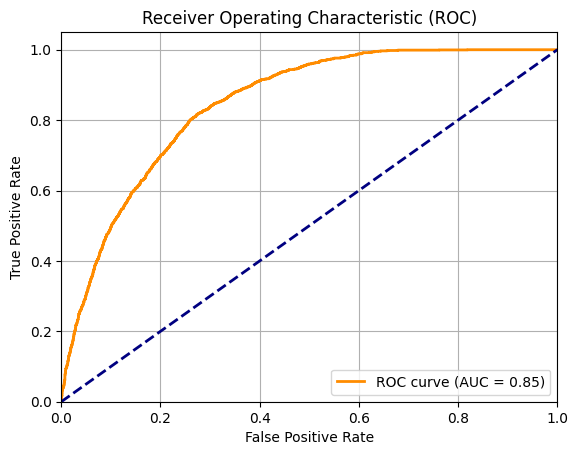

goal                                0.184990
launch_to_state_change_days         0.121971
category_grouped_Web                0.097930
create_to_launch_days               0.096485
launch_to_deadline_days             0.056706
                                      ...   
deadline_weekday_Sunday             0.000388
country_grouped_US                  0.000251
state_changed_at_weekday_Tuesday    0.000248
country_grouped_GB                  0.000083
currency_grouped_GBP                0.000002
Length: 73, dtype: float64
depth 3 n_estimators 200 learning rate 0.14 roc_auc 0.8450706429762948


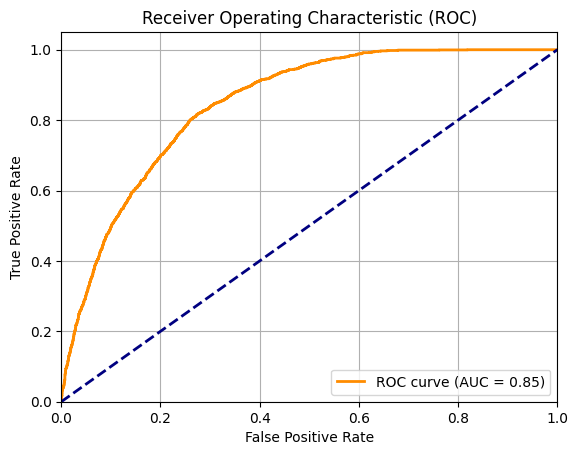

goal                                0.184990
launch_to_state_change_days         0.121971
category_grouped_Web                0.097930
create_to_launch_days               0.096485
launch_to_deadline_days             0.056706
                                      ...   
deadline_weekday_Sunday             0.000388
country_grouped_US                  0.000251
state_changed_at_weekday_Tuesday    0.000248
country_grouped_GB                  0.000083
currency_grouped_GBP                0.000002
Length: 73, dtype: float64
depth 4 n_estimators 200 learning rate 0.12000000000000001 roc_auc 0.8450706429762948


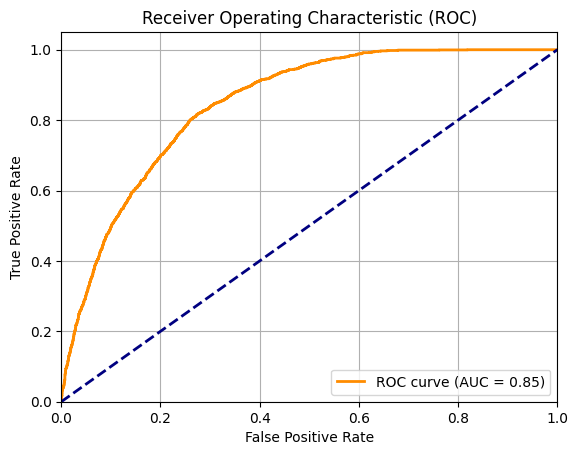

goal                                0.184990
launch_to_state_change_days         0.121971
category_grouped_Web                0.097930
create_to_launch_days               0.096485
launch_to_deadline_days             0.056706
                                      ...   
deadline_weekday_Sunday             0.000388
country_grouped_US                  0.000251
state_changed_at_weekday_Tuesday    0.000248
country_grouped_GB                  0.000083
currency_grouped_GBP                0.000002
Length: 73, dtype: float64
depth 4 n_estimators 200 learning rate 0.14 roc_auc 0.8450706429762948


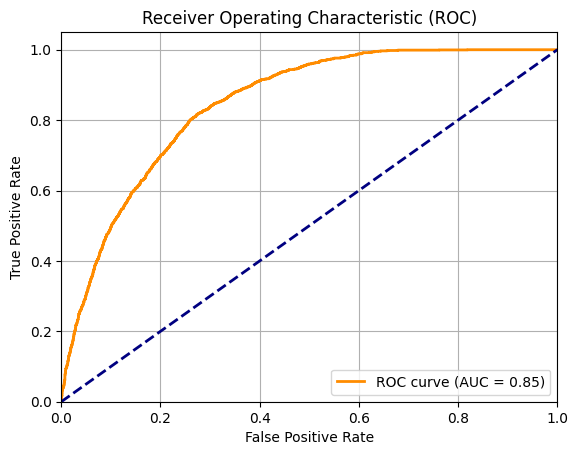

goal                                0.184990
launch_to_state_change_days         0.121971
category_grouped_Web                0.097930
create_to_launch_days               0.096485
launch_to_deadline_days             0.056706
                                      ...   
deadline_weekday_Sunday             0.000388
country_grouped_US                  0.000251
state_changed_at_weekday_Tuesday    0.000248
country_grouped_GB                  0.000083
currency_grouped_GBP                0.000002
Length: 73, dtype: float64
depth 3 n_estimators 250 learning rate 0.12000000000000001 roc_auc 0.8450706429762948


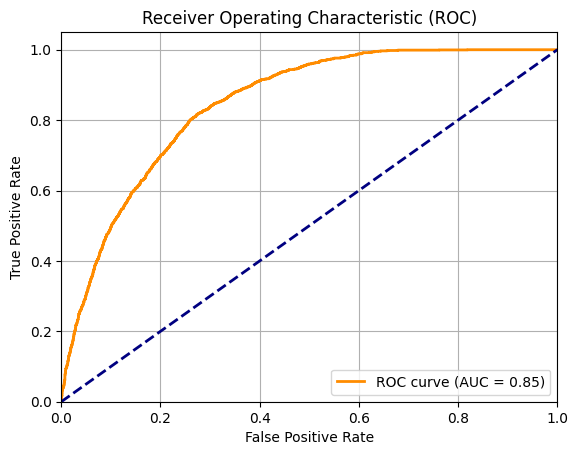

goal                                0.184990
launch_to_state_change_days         0.121971
category_grouped_Web                0.097930
create_to_launch_days               0.096485
launch_to_deadline_days             0.056706
                                      ...   
deadline_weekday_Sunday             0.000388
country_grouped_US                  0.000251
state_changed_at_weekday_Tuesday    0.000248
country_grouped_GB                  0.000083
currency_grouped_GBP                0.000002
Length: 73, dtype: float64
depth 3 n_estimators 250 learning rate 0.14 roc_auc 0.8450706429762948


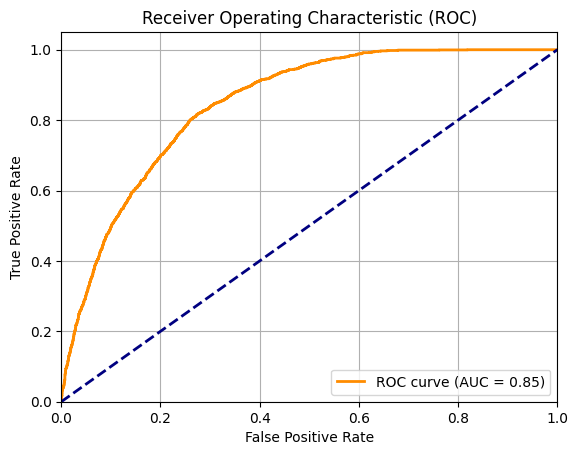

goal                                0.184990
launch_to_state_change_days         0.121971
category_grouped_Web                0.097930
create_to_launch_days               0.096485
launch_to_deadline_days             0.056706
                                      ...   
deadline_weekday_Sunday             0.000388
country_grouped_US                  0.000251
state_changed_at_weekday_Tuesday    0.000248
country_grouped_GB                  0.000083
currency_grouped_GBP                0.000002
Length: 73, dtype: float64
depth 4 n_estimators 250 learning rate 0.12000000000000001 roc_auc 0.8450706429762948


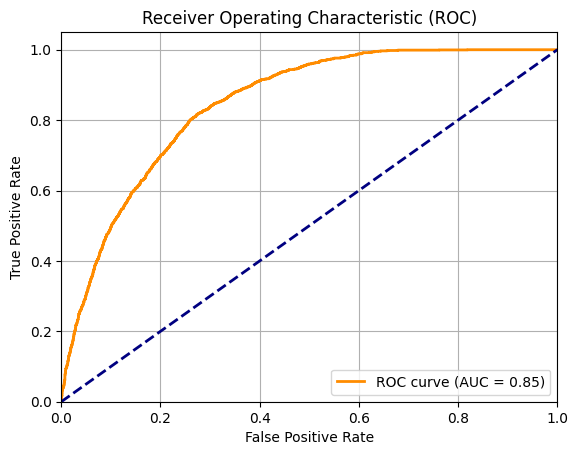

goal                                0.184990
launch_to_state_change_days         0.121971
category_grouped_Web                0.097930
create_to_launch_days               0.096485
launch_to_deadline_days             0.056706
                                      ...   
deadline_weekday_Sunday             0.000388
country_grouped_US                  0.000251
state_changed_at_weekday_Tuesday    0.000248
country_grouped_GB                  0.000083
currency_grouped_GBP                0.000002
Length: 73, dtype: float64
depth 4 n_estimators 250 learning rate 0.14 roc_auc 0.8450706429762948


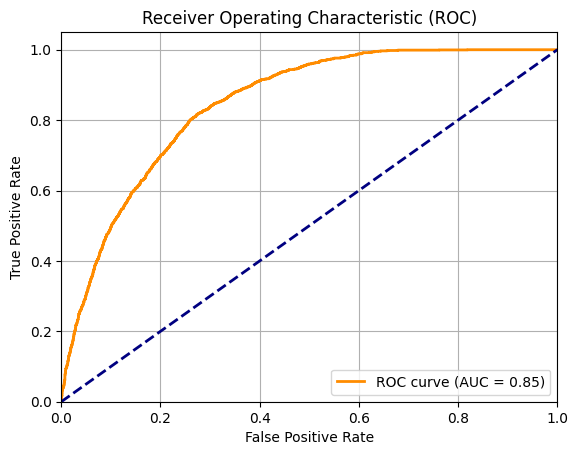

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model_score_stats = []

for i in range(1, 3):
    n_estimators = 150 + i * 50
    for j in range(1, 3):
        max_depth = 2 + j
        for k in range(1, 3):
            learning_rate = 0.1 + k * 0.02
            clf_Adaboost = GradientBoostingClassifier(n_estimators=200, max_depth=4, learning_rate=0.15, random_state=42)
            clf_Adaboost.fit(X_train, y_train)

            cv_scores = cross_val_score(clf_Adaboost, X, y, cv=10)

            #examine the feature importance
            importances = clf_Adaboost.feature_importances_
            feature_ranks = pd.Series(importances, index=X.columns).sort_values(ascending=False)
            filtered_ranks = feature_ranks[feature_ranks > 0]
            print(filtered_ranks)
            #for index, value in zip(feature_ranks.index, feature_ranks.values):
            #    print(index, value)
            #print(feature_ranks)
            #split_feature_index = clf.tree_.feature[0]
            #print("Split on feature:", X.columns[split_feature_index])

            #model_score_stats.append({"model": clf_Adaboost, "depth": i, "min_sample_split":min_sample_split, "mean_score": cv_scores.mean(), "score_std":cv_scores.std()})

            #print(f"Cross-validation scores: {cv_scores}")
            #print(f"Mean accuracy: {cv_scores.mean():.4f}")
            #print(f"Standard deviation of accuracy: {cv_scores.std():.4f}")

            y_scores = clf_Adaboost.predict_proba(X_test)[:, 1]  # Get probability for the positive class

            # Compute ROC curve and AUC
            fpr, tpr, thresholds = roc_curve(y_test, y_scores)
            roc_auc = auc(fpr, tpr)

            print(f"depth {max_depth} n_estimators {n_estimators} learning rate {learning_rate} roc_auc {roc_auc}")
            model_score_stats.append({"model": clf, "max_depth": max_depth, "n_estimators": n_estimators, "learning_rate": learning_rate, "roc_auc": roc_auc})

            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Chance line
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC)')
            plt.legend(loc='lower right')
            plt.grid()
            plt.show()

In [ ]:
#model_score_stats.append({"model": clf, "max_depth": max_depth, "n_estimators": n_estimators, "learning_rate": learning_rate, "roc_auc": roc_auc})

max_score = max(model_score_stats, key=lambda x: x['roc_auc'])
#min_std = min(model_score_stats, key=lambda x: x['score_std'])

print(f"maximum roc_auc score parameters {max_score}")
#print(f"minimum score standard deviation parameters {min_std}")


maximum roc_auc score parameters {'model': DecisionTreeClassifier(max_depth=9, min_samples_leaf=14, random_state=42), 'max_depth': 3, 'n_estimators': 200, 'learning_rate': 0.12000000000000001, 'roc_auc': np.float64(0.8450706429762948)}


Best n_estimators: 350


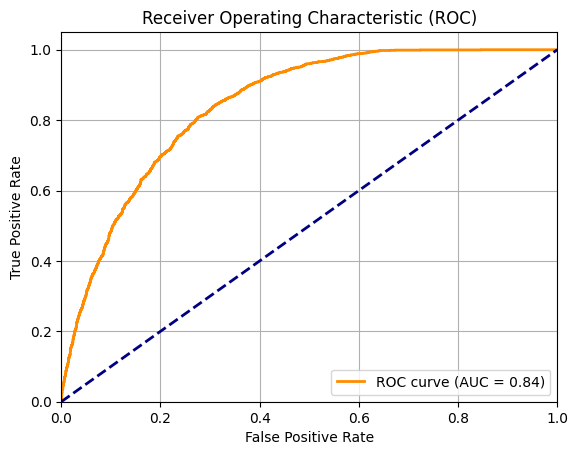

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [350]}
grid = GridSearchCV(GradientBoostingClassifier(learning_rate=0.15, max_depth=4), params, cv=10)
grid.fit(X_train, y_train)
print("Best n_estimators:", grid.best_params_['n_estimators'])

y_scores = grid.predict_proba(X_test)[:, 1]  # Get probability for the positive class

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)



plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Random Forest ##

Index(['goal', 'static_usd_rate', 'name_len_clean', 'blurb_len_clean',
       'deadline_month', 'deadline_day', 'deadline_hr', 'created_at_month',
       'created_at_day', 'created_at_hr', 'launched_at_month',
       'launched_at_day', 'launched_at_yr', 'launched_at_hr',
       'create_to_launch_days', 'launch_to_deadline_days',
       'launch_to_state_change_days', 'TOPCOUNTRY', 'LaunchedTuesday',
       'DeadlineWeekend', 'disable_communication', 'app', 'help', 'new',
       'world', 'canceled', 'country_grouped_CA', 'country_grouped_GB',
       'country_grouped_Other', 'country_grouped_US', 'currency_grouped_CAD',
       'currency_grouped_EUR', 'currency_grouped_GBP',
       'currency_grouped_Other', 'currency_grouped_USD',
       'deadline_weekday_Friday', 'deadline_weekday_Monday',
       'deadline_weekday_Saturday', 'deadline_weekday_Sunday',
       'deadline_weekday_Thursday', 'deadline_weekday_Tuesday',
       'deadline_weekday_Wednesday', 'state_changed_at_weekday_Friday',
   

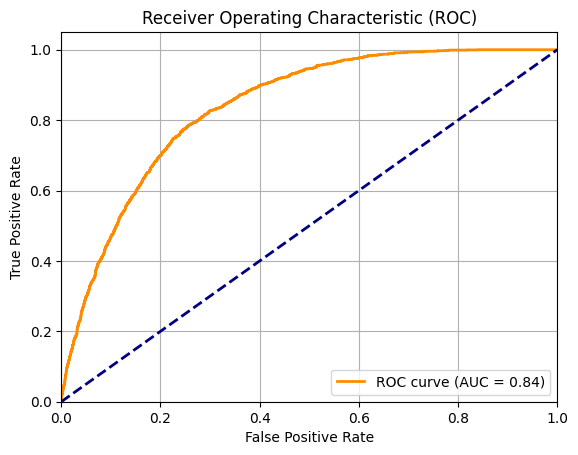

Feature ranking:
1. goal: 0.1924
2. category_grouped_Web: 0.1047
3. launch_to_state_change_days: 0.1008
4. create_to_launch_days: 0.0730
5. canceled: 0.0625
6. launch_to_deadline_days: 0.0457
7. category_grouped_Software: 0.0457
8. category_grouped_Plays: 0.0382
9. category_grouped_Other: 0.0381
10. launched_at_yr: 0.0379
11. launched_at_hr: 0.0255
12. deadline_hr: 0.0206
13. name_len_clean: 0.0202
14. deadline_day: 0.0133
15. created_at_day: 0.0131
16. created_at_hr: 0.0128
17. launched_at_day: 0.0128
18. category_grouped_Musical: 0.0117
19. created_at_month: 0.0110
20. deadline_month: 0.0106
21. launched_at_month: 0.0101
22. static_usd_rate: 0.0094
23. TOPCOUNTRY: 0.0075
24. category_grouped_Hardware: 0.0068
25. new: 0.0047
26. LaunchedTuesday: 0.0039
27. launched_at_weekday_Tuesday: 0.0038
28. country_grouped_Other: 0.0035
29. category_grouped_Gadgets: 0.0030
30. world: 0.0030
31. currency_grouped_USD: 0.0030
32. blurb_len_clean: 0.0027
33. DeadlineWeekend: 0.0027
34. country_groupe

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

'''
22. static_usd_rate: 0.0098
23. category_grouped_Hardware: 0.0075
24. TOPCOUNTRY: 0.0074
25. new: 0.0052
26. LaunchedTuesday: 0.0044
27. launched_at_weekday_Tuesday: 0.0042
28. country_grouped_Other: 0.0041
29. category_grouped_Gadgets: 0.0036
30. currency_grouped_USD: 0.0034
31. country_grouped_US: 0.0030
32. DeadlineWeekend: 0.0028
33. world: 0.0026
34. disable_communication: 0.0024
35. currency_grouped_GBP: 0.0023
36. country_grouped_GB: 0.0023
37. launched_at_weekday_Friday: 0.0022
38. currency_grouped_EUR: 0.0020
39. created_at_weekday_Tuesday: 0.0019
40. deadline_weekday_Thursday: 0.0014
41. deadline_weekday_Friday: 0.0014
42. created_at_weekday_Monday: 0.0014
43. app: 0.0014
44. launched_at_weekday_Wednesday: 0.0014
45. launched_at_weekday_Thursday: 0.0012
46. created_at_weekday_Thursday: 0.0012
47. deadline_weekday_Saturday: 0.0012
48. help: 0.0012
49. launched_at_weekday_Monday: 0.0012
50. category_grouped_Apps: 0.0012
51. deadline_weekday_Tuesday: 0.0011
52. category_grouped_Sound: 0.0011
53. deadline_weekday_Sunday: 0.0010
54. deadline_weekday_Wednesday: 0.0010
55. created_at_weekday_Wednesday: 0.0009
56. category_grouped_Wearables: 0.0008
57. created_at_weekday_Friday: 0.0008
58. currency_grouped_CAD: 0.0007
59. country_grouped_CA: 0.0006
60. created_at_weekday_Saturday: 0.0006
61. created_at_weekday_Sunday: 0.0006
62. deadline_weekday_Monday: 0.0005
63. currency_grouped_Other: 0.0004
64. launched_at_weekday_Sunday: 0.0004
65. launched_at_weekday_Saturday: 0.0003
'''

print(X_train.columns)
#X_train.drop('name_len_clean', inplace=True, axis=1)
#X_test.drop('name_len_clean', inplace=True, axis=1)

rf = RandomForestClassifier(n_estimators=650, max_depth=25, random_state=42, min_samples_leaf=30)
rf.fit(X_train, y_train)

y_scores = rf.predict_proba(X_test)[:, 1]  # Get probability for the positive class

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

importances = rf.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

# Print top features
print("Feature ranking:")
for i in range(len(feature_names)):
    print(f"{i + 1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")


Let's try it again but remove all the features with ranking of less than 0.01.

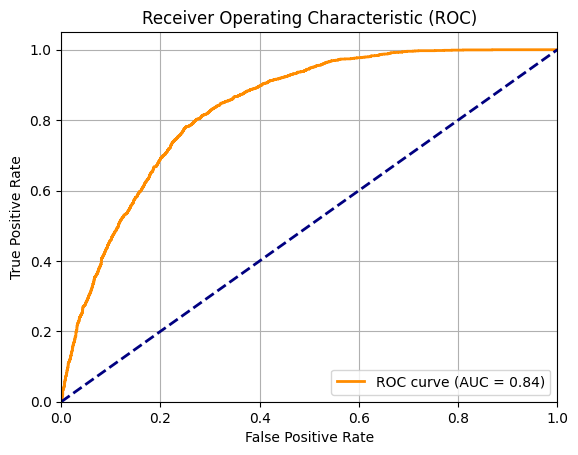

Feature ranking:
1. goal: 0.1923
2. launch_to_state_change_days: 0.1036
3. category_grouped_Web: 0.0960
4. create_to_launch_days: 0.0889
5. canceled: 0.0593
6. launch_to_deadline_days: 0.0483
7. category_grouped_Software: 0.0449
8. launched_at_yr: 0.0405
9. launched_at_hr: 0.0351
10. category_grouped_Plays: 0.0308
11. deadline_hr: 0.0304
12. category_grouped_Other: 0.0291
13. deadline_day: 0.0251
14. created_at_day: 0.0247
15. created_at_hr: 0.0241
16. launched_at_day: 0.0240
17. name_len_clean: 0.0203
18. created_at_month: 0.0177
19. deadline_month: 0.0174
20. launched_at_month: 0.0164
21. category_grouped_Musical: 0.0110
22. blurb_len_clean: 0.0045
23. state_changed_at_weekday_Thursday: 0.0030
24. state_changed_at_weekday_Saturday: 0.0026
25. state_changed_at_weekday_Friday: 0.0025
26. state_changed_at_weekday_Wednesday: 0.0022
27. state_changed_at_weekday_Sunday: 0.0018
28. state_changed_at_weekday_Tuesday: 0.0017
29. state_changed_at_weekday_Monday: 0.0015


In [ ]:
low_weight_features_drop = [
    "static_usd_rate",
    "category_grouped_Hardware",
    "TOPCOUNTRY",
    "new",
    "LaunchedTuesday",
    "launched_at_weekday_Tuesday",
    "country_grouped_Other",
    "category_grouped_Gadgets",
    "currency_grouped_USD",
    "country_grouped_US",
    "DeadlineWeekend",
    "world",
    "disable_communication",
    "currency_grouped_GBP",
    "country_grouped_GB",
    "launched_at_weekday_Friday",
    "currency_grouped_EUR",
    "created_at_weekday_Tuesday",
    "deadline_weekday_Thursday",
    "deadline_weekday_Friday",
    "created_at_weekday_Monday",
    "app",
    "launched_at_weekday_Wednesday",
    "launched_at_weekday_Thursday",
    "created_at_weekday_Thursday",
    "deadline_weekday_Saturday",
    "help",
    "launched_at_weekday_Monday",
    "category_grouped_Apps",
    "deadline_weekday_Tuesday",
    "category_grouped_Sound",
    "deadline_weekday_Sunday",
    "deadline_weekday_Wednesday",
    "created_at_weekday_Wednesday",
    "category_grouped_Wearables",
    "created_at_weekday_Friday",
    "currency_grouped_CAD",
    "country_grouped_CA",
    "created_at_weekday_Saturday",
    "created_at_weekday_Sunday",
    "deadline_weekday_Monday",
    "currency_grouped_Other",
    "launched_at_weekday_Sunday",
    "launched_at_weekday_Saturday"
]

try:
    X_train.drop(columns=low_weight_features_drop, axis=1, inplace=True)
    X_test.drop(columns=low_weight_features_drop, axis=1, inplace=True)
except:
    pass


rf = RandomForestClassifier(n_estimators=650, max_depth=20, random_state=42, min_samples_leaf=15)
rf.fit(X_train, y_train)

y_scores = rf.predict_proba(X_test)[:, 1]  # Get probability for the positive class

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

importances = rf.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]

# Print top features
print("Feature ranking:")
for i in range(len(feature_names)):
    print(f"{i + 1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")
